# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

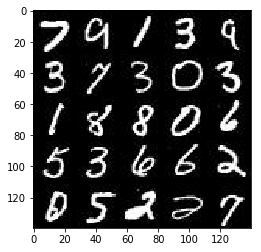

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

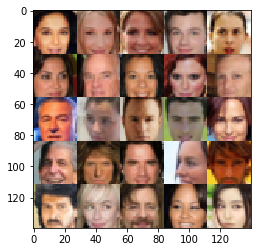

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
tf.reset_default_graph()

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        #28x28x3 ---> 14, 14, 128
        conv1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        assert conv1.get_shape()[1:] == (14, 14, 128), conv1.get_shape()
        
        #14, 14, 128 ---> 7, 7, 256
        conv2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * conv2, conv2)
        assert conv2.get_shape()[1:] == (7, 7, 256), conv2.get_shape()
        
        #7, 7, 256 ----> 4, 4, 512
        conv3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * conv3, conv3)
        assert conv3.get_shape()[1:] == (4, 4, 512), conv3.get_shape()

        # Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
tf.reset_default_graph()
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        conv1 = tf.layers.dense(z, 2 * 2 * 512)
        
        # first deconvolution
        conv1 = tf.reshape(conv1, (-1, 2, 2, 512))
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        assert conv1.get_shape()[1:] == (2, 2, 512), conv1.get_shape()
        
        # second deconvolution
        conv2 = tf.layers.conv2d_transpose(conv1, 256, 5, strides=2, padding='valid')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        assert conv2.get_shape()[1:] == (7, 7, 256), conv2.get_shape()
        
        # third deconvolution
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(alpha * conv3, conv3)
        assert conv3.get_shape()[1:] == (14, 14, 128), conv3.get_shape()
        
        # Output layer
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 5, strides=2, padding='same')
        assert logits.get_shape()[1:] == (28, 28, out_channel_dim), logits.get_shape()
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.9
    
    # Build the model
    g_model = generator(input_z, out_channel_dim, is_train=True)
    # g_model is the generator output

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * smooth))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake) * smooth))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            d_losses = []
            g_losses = []
            for b, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _, dis_loss = sess.run([d_train_opt, d_loss], feed_dict={input_real: batch_images * 2, input_z: batch_z, learn_rate: learning_rate})
                _, gen_loss = sess.run([g_train_opt, g_loss], feed_dict={input_real: batch_images * 2, input_z: batch_z, learn_rate: learning_rate})
                
                d_losses.append(dis_loss)
                g_losses.append(gen_loss)
                
                print('Batch: {} - Discriminator Loss: {} - Generator Loss: {}'.format(b, dis_loss, gen_loss))
                
                if b % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Batch: 0 - Discriminator Loss: 1.257212519645691 - Generator Loss: 20.9467716217041


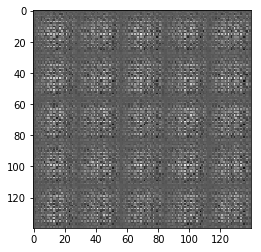

Batch: 1 - Discriminator Loss: 21.88526725769043 - Generator Loss: 26.166519165039062
Batch: 2 - Discriminator Loss: 1.172987937927246 - Generator Loss: 19.108747482299805
Batch: 3 - Discriminator Loss: 2.7919416427612305 - Generator Loss: 36.37403869628906
Batch: 4 - Discriminator Loss: 12.07162857055664 - Generator Loss: 26.872486114501953
Batch: 5 - Discriminator Loss: 1.6370362043380737 - Generator Loss: 8.115346908569336
Batch: 6 - Discriminator Loss: 18.92719078063965 - Generator Loss: 26.93893814086914
Batch: 7 - Discriminator Loss: 1.7758811712265015 - Generator Loss: 22.050907135009766
Batch: 8 - Discriminator Loss: 0.7459138035774231 - Generator Loss: 11.540365219116211
Batch: 9 - Discriminator Loss: 2.957709550857544 - Generator Loss: 30.768840789794922
Batch: 10 - Discriminator Loss: 9.453229904174805 - Generator Loss: 23.277528762817383
Batch: 11 - Discriminator Loss: 0.8760756254196167 - Generator Loss: 13.908470153808594
Batch: 12 - Discriminator Loss: 2.433432102203369 

Batch: 96 - Discriminator Loss: 0.7045514583587646 - Generator Loss: 7.574041366577148
Batch: 97 - Discriminator Loss: 0.6406763195991516 - Generator Loss: 4.003656387329102
Batch: 98 - Discriminator Loss: 0.846410870552063 - Generator Loss: 8.850404739379883
Batch: 99 - Discriminator Loss: 0.9317408204078674 - Generator Loss: 5.165597915649414
Batch: 100 - Discriminator Loss: 0.5971606969833374 - Generator Loss: 4.906764984130859


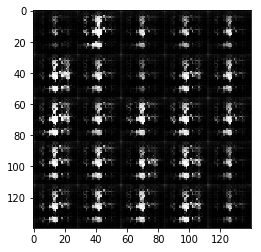

Batch: 101 - Discriminator Loss: 0.6124975085258484 - Generator Loss: 5.79979944229126
Batch: 102 - Discriminator Loss: 0.5737005472183228 - Generator Loss: 3.4567317962646484
Batch: 103 - Discriminator Loss: 0.8379905819892883 - Generator Loss: 8.18716812133789
Batch: 104 - Discriminator Loss: 0.8179992437362671 - Generator Loss: 4.3312883377075195
Batch: 105 - Discriminator Loss: 0.6870239973068237 - Generator Loss: 6.720415115356445
Batch: 106 - Discriminator Loss: 0.6308866143226624 - Generator Loss: 4.024428844451904
Batch: 107 - Discriminator Loss: 0.49629366397857666 - Generator Loss: 4.450230598449707
Batch: 108 - Discriminator Loss: 0.4927021265029907 - Generator Loss: 4.419656753540039
Batch: 109 - Discriminator Loss: 0.6151973605155945 - Generator Loss: 2.8201308250427246
Batch: 110 - Discriminator Loss: 0.6809242963790894 - Generator Loss: 6.840564727783203
Batch: 111 - Discriminator Loss: 0.8381669521331787 - Generator Loss: 3.8068861961364746
Batch: 112 - Discriminator Lo

Batch: 194 - Discriminator Loss: 1.2889765501022339 - Generator Loss: 1.3628816604614258
Batch: 195 - Discriminator Loss: 1.405848503112793 - Generator Loss: 4.7475786209106445
Batch: 196 - Discriminator Loss: 1.6260813474655151 - Generator Loss: 1.2557971477508545
Batch: 197 - Discriminator Loss: 1.6110502481460571 - Generator Loss: 6.918164253234863
Batch: 198 - Discriminator Loss: 1.1418476104736328 - Generator Loss: 2.567686080932617
Batch: 199 - Discriminator Loss: 1.0935840606689453 - Generator Loss: 2.8958568572998047
Batch: 200 - Discriminator Loss: 1.1976094245910645 - Generator Loss: 2.045309066772461


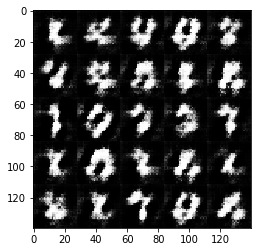

Batch: 201 - Discriminator Loss: 1.3272151947021484 - Generator Loss: 2.2305729389190674
Batch: 202 - Discriminator Loss: 1.0052075386047363 - Generator Loss: 1.6518837213516235
Batch: 203 - Discriminator Loss: 0.9897733926773071 - Generator Loss: 3.142207384109497
Batch: 204 - Discriminator Loss: 1.1462687253952026 - Generator Loss: 0.929087221622467
Batch: 205 - Discriminator Loss: 1.3577747344970703 - Generator Loss: 5.412635326385498
Batch: 206 - Discriminator Loss: 2.3234331607818604 - Generator Loss: 0.9703346490859985
Batch: 207 - Discriminator Loss: 1.565793514251709 - Generator Loss: 4.492551803588867
Batch: 208 - Discriminator Loss: 1.005278468132019 - Generator Loss: 1.7179147005081177
Batch: 209 - Discriminator Loss: 1.4025349617004395 - Generator Loss: 3.8086390495300293
Batch: 210 - Discriminator Loss: 1.3787918090820312 - Generator Loss: 1.5352592468261719
Batch: 211 - Discriminator Loss: 1.549046516418457 - Generator Loss: 4.131929397583008
Batch: 212 - Discriminator Lo

Batch: 294 - Discriminator Loss: 1.641387701034546 - Generator Loss: 3.2879483699798584
Batch: 295 - Discriminator Loss: 1.5937950611114502 - Generator Loss: 0.7294361591339111
Batch: 296 - Discriminator Loss: 1.493577241897583 - Generator Loss: 3.2294921875
Batch: 297 - Discriminator Loss: 1.6475950479507446 - Generator Loss: 0.8136467933654785
Batch: 298 - Discriminator Loss: 1.508866786956787 - Generator Loss: 3.458970069885254
Batch: 299 - Discriminator Loss: 1.5158358812332153 - Generator Loss: 0.9803380370140076
Batch: 300 - Discriminator Loss: 1.4351626634597778 - Generator Loss: 3.473313331604004


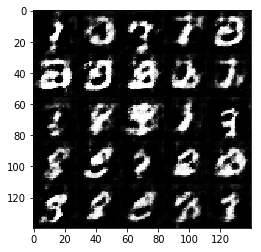

Batch: 301 - Discriminator Loss: 1.1183792352676392 - Generator Loss: 1.3812580108642578
Batch: 302 - Discriminator Loss: 0.9487652778625488 - Generator Loss: 2.2893619537353516
Batch: 303 - Discriminator Loss: 0.8675093054771423 - Generator Loss: 2.0665669441223145
Batch: 304 - Discriminator Loss: 1.0817842483520508 - Generator Loss: 1.362514615058899
Batch: 305 - Discriminator Loss: 1.0752733945846558 - Generator Loss: 2.9623537063598633
Batch: 306 - Discriminator Loss: 1.0983654260635376 - Generator Loss: 1.0277329683303833
Batch: 307 - Discriminator Loss: 1.2859411239624023 - Generator Loss: 3.9990456104278564
Batch: 308 - Discriminator Loss: 1.3693645000457764 - Generator Loss: 1.2627638578414917
Batch: 309 - Discriminator Loss: 1.2015531063079834 - Generator Loss: 2.508272647857666
Batch: 310 - Discriminator Loss: 1.1427301168441772 - Generator Loss: 1.4227720499038696
Batch: 311 - Discriminator Loss: 1.1504477262496948 - Generator Loss: 3.2728867530822754
Batch: 312 - Discrimina

Batch: 394 - Discriminator Loss: 1.5468690395355225 - Generator Loss: 3.0628557205200195
Batch: 395 - Discriminator Loss: 1.336776614189148 - Generator Loss: 0.7894948124885559
Batch: 396 - Discriminator Loss: 1.2302664518356323 - Generator Loss: 2.2077484130859375
Batch: 397 - Discriminator Loss: 1.0110360383987427 - Generator Loss: 1.722376823425293
Batch: 398 - Discriminator Loss: 1.1425631046295166 - Generator Loss: 1.2778093814849854
Batch: 399 - Discriminator Loss: 0.9993575215339661 - Generator Loss: 1.9303216934204102
Batch: 400 - Discriminator Loss: 1.1953729391098022 - Generator Loss: 1.126641035079956


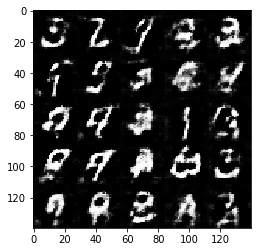

Batch: 401 - Discriminator Loss: 1.1972423791885376 - Generator Loss: 2.7299036979675293
Batch: 402 - Discriminator Loss: 1.288515567779541 - Generator Loss: 0.971157431602478
Batch: 403 - Discriminator Loss: 1.1297810077667236 - Generator Loss: 2.5347185134887695
Batch: 404 - Discriminator Loss: 1.1286638975143433 - Generator Loss: 0.977149248123169
Batch: 405 - Discriminator Loss: 1.274561882019043 - Generator Loss: 3.518972873687744
Batch: 406 - Discriminator Loss: 1.493623971939087 - Generator Loss: 0.871112585067749
Batch: 407 - Discriminator Loss: 1.4018571376800537 - Generator Loss: 2.9213366508483887
Batch: 408 - Discriminator Loss: 1.4351871013641357 - Generator Loss: 0.6427139043807983
Batch: 409 - Discriminator Loss: 1.7421061992645264 - Generator Loss: 3.160348415374756
Batch: 410 - Discriminator Loss: 1.493580937385559 - Generator Loss: 0.7747088670730591
Batch: 411 - Discriminator Loss: 1.3868863582611084 - Generator Loss: 2.9088034629821777
Batch: 412 - Discriminator Los

Batch: 494 - Discriminator Loss: 1.1817783117294312 - Generator Loss: 3.149287700653076
Batch: 495 - Discriminator Loss: 1.6216309070587158 - Generator Loss: 0.5857314467430115
Batch: 496 - Discriminator Loss: 1.7624080181121826 - Generator Loss: 4.0800676345825195
Batch: 497 - Discriminator Loss: 2.1352193355560303 - Generator Loss: 0.7626101970672607
Batch: 498 - Discriminator Loss: 1.5180577039718628 - Generator Loss: 2.578763008117676
Batch: 499 - Discriminator Loss: 1.2989424467086792 - Generator Loss: 1.0055890083312988
Batch: 500 - Discriminator Loss: 1.0845494270324707 - Generator Loss: 2.079184055328369


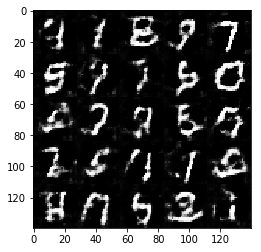

Batch: 501 - Discriminator Loss: 1.0540580749511719 - Generator Loss: 1.0211557149887085
Batch: 502 - Discriminator Loss: 1.3431055545806885 - Generator Loss: 3.0274364948272705
Batch: 503 - Discriminator Loss: 1.3989964723587036 - Generator Loss: 0.7543100118637085
Batch: 504 - Discriminator Loss: 1.4133248329162598 - Generator Loss: 3.318253517150879
Batch: 505 - Discriminator Loss: 1.2473540306091309 - Generator Loss: 0.9915822744369507
Batch: 506 - Discriminator Loss: 1.3205444812774658 - Generator Loss: 2.763885498046875
Batch: 507 - Discriminator Loss: 1.4719816446304321 - Generator Loss: 0.6361397504806519
Batch: 508 - Discriminator Loss: 1.6524244546890259 - Generator Loss: 3.2394309043884277
Batch: 509 - Discriminator Loss: 1.2454020977020264 - Generator Loss: 1.0651881694793701
Batch: 510 - Discriminator Loss: 1.243541955947876 - Generator Loss: 2.776618480682373
Batch: 511 - Discriminator Loss: 1.6547768115997314 - Generator Loss: 0.5799663662910461
Batch: 512 - Discriminato

Batch: 594 - Discriminator Loss: 1.0844074487686157 - Generator Loss: 0.9939361214637756
Batch: 595 - Discriminator Loss: 1.1301288604736328 - Generator Loss: 2.299980878829956
Batch: 596 - Discriminator Loss: 1.3547377586364746 - Generator Loss: 1.2412166595458984
Batch: 597 - Discriminator Loss: 1.1830453872680664 - Generator Loss: 2.202303886413574
Batch: 598 - Discriminator Loss: 1.1572481393814087 - Generator Loss: 0.9269559383392334
Batch: 599 - Discriminator Loss: 1.1781270503997803 - Generator Loss: 3.2838711738586426
Batch: 600 - Discriminator Loss: 1.7248992919921875 - Generator Loss: 0.5611512660980225


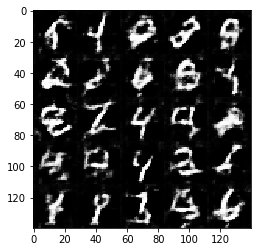

Batch: 601 - Discriminator Loss: 1.5841209888458252 - Generator Loss: 3.324528455734253
Batch: 602 - Discriminator Loss: 1.4339759349822998 - Generator Loss: 0.9460203647613525
Batch: 603 - Discriminator Loss: 1.2115116119384766 - Generator Loss: 2.140238046646118
Batch: 604 - Discriminator Loss: 0.9830492734909058 - Generator Loss: 1.2904384136199951
Batch: 605 - Discriminator Loss: 1.0407992601394653 - Generator Loss: 1.896328091621399
Batch: 606 - Discriminator Loss: 1.0096826553344727 - Generator Loss: 1.2683535814285278
Batch: 607 - Discriminator Loss: 1.2491506338119507 - Generator Loss: 2.669624090194702
Batch: 608 - Discriminator Loss: 1.1460940837860107 - Generator Loss: 0.8198726177215576
Batch: 609 - Discriminator Loss: 1.3418303728103638 - Generator Loss: 3.2622323036193848
Batch: 610 - Discriminator Loss: 1.3807704448699951 - Generator Loss: 0.7809942364692688
Batch: 611 - Discriminator Loss: 1.2051520347595215 - Generator Loss: 2.5393123626708984
Batch: 612 - Discriminato

Batch: 694 - Discriminator Loss: 1.3470416069030762 - Generator Loss: 3.431912422180176
Batch: 695 - Discriminator Loss: 1.3757792711257935 - Generator Loss: 0.7828748226165771
Batch: 696 - Discriminator Loss: 1.1361802816390991 - Generator Loss: 2.631983757019043
Batch: 697 - Discriminator Loss: 0.9984774589538574 - Generator Loss: 1.241590142250061
Batch: 698 - Discriminator Loss: 1.1335811614990234 - Generator Loss: 1.904263973236084
Batch: 699 - Discriminator Loss: 0.990443229675293 - Generator Loss: 1.4464986324310303
Batch: 700 - Discriminator Loss: 0.99285489320755 - Generator Loss: 2.0567893981933594


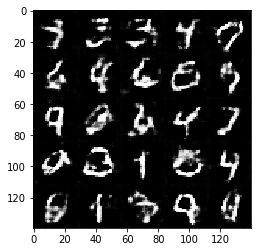

Batch: 701 - Discriminator Loss: 0.8667694926261902 - Generator Loss: 1.5984468460083008
Batch: 702 - Discriminator Loss: 0.9063385725021362 - Generator Loss: 1.4957695007324219
Batch: 703 - Discriminator Loss: 1.0714339017868042 - Generator Loss: 2.9321658611297607
Batch: 704 - Discriminator Loss: 1.4221298694610596 - Generator Loss: 0.5468744039535522
Batch: 705 - Discriminator Loss: 1.5917637348175049 - Generator Loss: 3.4085171222686768
Batch: 706 - Discriminator Loss: 1.4642492532730103 - Generator Loss: 0.8669384717941284
Batch: 707 - Discriminator Loss: 1.2878239154815674 - Generator Loss: 2.6935644149780273
Batch: 708 - Discriminator Loss: 1.1523199081420898 - Generator Loss: 1.2877132892608643
Batch: 709 - Discriminator Loss: 1.0725858211517334 - Generator Loss: 2.3198142051696777
Batch: 710 - Discriminator Loss: 1.2066107988357544 - Generator Loss: 1.1136932373046875
Batch: 711 - Discriminator Loss: 1.1768666505813599 - Generator Loss: 2.3399014472961426
Batch: 712 - Discrimi

Batch: 794 - Discriminator Loss: 1.1144483089447021 - Generator Loss: 2.4960925579071045
Batch: 795 - Discriminator Loss: 1.086402177810669 - Generator Loss: 1.1146036386489868
Batch: 796 - Discriminator Loss: 1.212266206741333 - Generator Loss: 2.5959157943725586
Batch: 797 - Discriminator Loss: 1.0915775299072266 - Generator Loss: 1.255258321762085
Batch: 798 - Discriminator Loss: 1.0218923091888428 - Generator Loss: 2.1093077659606934
Batch: 799 - Discriminator Loss: 0.8531931042671204 - Generator Loss: 1.6830470561981201
Batch: 800 - Discriminator Loss: 1.1112759113311768 - Generator Loss: 2.5105834007263184


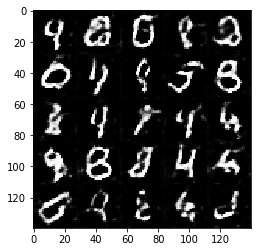

Batch: 801 - Discriminator Loss: 1.0038586854934692 - Generator Loss: 1.255064845085144
Batch: 802 - Discriminator Loss: 1.037335753440857 - Generator Loss: 2.68887996673584
Batch: 803 - Discriminator Loss: 1.1188056468963623 - Generator Loss: 0.9298093318939209
Batch: 804 - Discriminator Loss: 1.0241702795028687 - Generator Loss: 3.152719497680664
Batch: 805 - Discriminator Loss: 1.2066045999526978 - Generator Loss: 0.864744246006012
Batch: 806 - Discriminator Loss: 1.4539830684661865 - Generator Loss: 3.5750255584716797
Batch: 807 - Discriminator Loss: 1.7665209770202637 - Generator Loss: 0.5424976348876953
Batch: 808 - Discriminator Loss: 1.6044938564300537 - Generator Loss: 3.2633743286132812
Batch: 809 - Discriminator Loss: 1.5185858011245728 - Generator Loss: 0.713823676109314
Batch: 810 - Discriminator Loss: 1.0717854499816895 - Generator Loss: 2.801957130432129
Batch: 811 - Discriminator Loss: 1.200641393661499 - Generator Loss: 0.8365190029144287
Batch: 812 - Discriminator Los

Batch: 894 - Discriminator Loss: 1.4742491245269775 - Generator Loss: 3.309112548828125
Batch: 895 - Discriminator Loss: 1.6906412839889526 - Generator Loss: 0.47931522130966187
Batch: 896 - Discriminator Loss: 1.9462721347808838 - Generator Loss: 3.8843464851379395
Batch: 897 - Discriminator Loss: 1.8060996532440186 - Generator Loss: 0.6947237253189087
Batch: 898 - Discriminator Loss: 1.5713341236114502 - Generator Loss: 2.8550610542297363
Batch: 899 - Discriminator Loss: 1.4193150997161865 - Generator Loss: 0.8799874782562256
Batch: 900 - Discriminator Loss: 1.2594053745269775 - Generator Loss: 2.6312317848205566


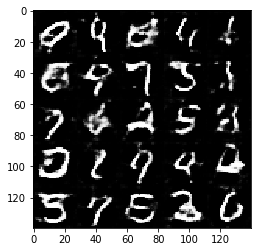

Batch: 901 - Discriminator Loss: 1.335592269897461 - Generator Loss: 0.8527575731277466
Batch: 902 - Discriminator Loss: 1.0781052112579346 - Generator Loss: 2.7168986797332764
Batch: 903 - Discriminator Loss: 1.0354653596878052 - Generator Loss: 1.2763512134552002
Batch: 904 - Discriminator Loss: 1.1110310554504395 - Generator Loss: 2.466330051422119
Batch: 905 - Discriminator Loss: 1.049531102180481 - Generator Loss: 1.22782301902771
Batch: 906 - Discriminator Loss: 1.1173255443572998 - Generator Loss: 1.6518810987472534
Batch: 907 - Discriminator Loss: 0.8767268061637878 - Generator Loss: 2.0655100345611572
Batch: 908 - Discriminator Loss: 0.9650043249130249 - Generator Loss: 1.6114110946655273
Batch: 909 - Discriminator Loss: 0.8571401238441467 - Generator Loss: 2.4030230045318604
Batch: 910 - Discriminator Loss: 0.9673398733139038 - Generator Loss: 1.118337631225586
Batch: 911 - Discriminator Loss: 1.0332447290420532 - Generator Loss: 3.119049072265625
Batch: 912 - Discriminator L

Batch: 994 - Discriminator Loss: 1.0110838413238525 - Generator Loss: 2.0686721801757812
Batch: 995 - Discriminator Loss: 0.8824079036712646 - Generator Loss: 1.3883984088897705
Batch: 996 - Discriminator Loss: 0.9025938510894775 - Generator Loss: 1.9418054819107056
Batch: 997 - Discriminator Loss: 0.7359504699707031 - Generator Loss: 2.056706190109253
Batch: 998 - Discriminator Loss: 0.8424558043479919 - Generator Loss: 1.423439621925354
Batch: 999 - Discriminator Loss: 0.9742646217346191 - Generator Loss: 2.004436492919922
Batch: 1000 - Discriminator Loss: 0.9550740718841553 - Generator Loss: 2.3643414974212646


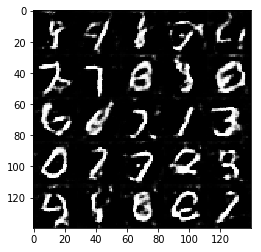

Batch: 1001 - Discriminator Loss: 1.081028938293457 - Generator Loss: 0.857817530632019
Batch: 1002 - Discriminator Loss: 1.202934980392456 - Generator Loss: 3.033257246017456
Batch: 1003 - Discriminator Loss: 0.9455170035362244 - Generator Loss: 1.283360481262207
Batch: 1004 - Discriminator Loss: 0.7787501811981201 - Generator Loss: 2.326371192932129
Batch: 1005 - Discriminator Loss: 0.98899906873703 - Generator Loss: 1.3466687202453613
Batch: 1006 - Discriminator Loss: 0.8214395046234131 - Generator Loss: 3.2902355194091797
Batch: 1007 - Discriminator Loss: 0.9110050201416016 - Generator Loss: 1.1410012245178223
Batch: 1008 - Discriminator Loss: 1.1105248928070068 - Generator Loss: 3.487337589263916
Batch: 1009 - Discriminator Loss: 0.973548173904419 - Generator Loss: 1.3868014812469482
Batch: 1010 - Discriminator Loss: 0.912315309047699 - Generator Loss: 2.684913396835327
Batch: 1011 - Discriminator Loss: 0.9729392528533936 - Generator Loss: 1.5863537788391113
Batch: 1012 - Discrimi

Batch: 1093 - Discriminator Loss: 0.7463345527648926 - Generator Loss: 2.360520839691162
Batch: 1094 - Discriminator Loss: 0.789036214351654 - Generator Loss: 1.3778671026229858
Batch: 1095 - Discriminator Loss: 0.7185633182525635 - Generator Loss: 2.853005886077881
Batch: 1096 - Discriminator Loss: 0.810712456703186 - Generator Loss: 1.9654858112335205
Batch: 1097 - Discriminator Loss: 0.6509801149368286 - Generator Loss: 1.8334507942199707
Batch: 1098 - Discriminator Loss: 0.8352246284484863 - Generator Loss: 1.5842883586883545
Batch: 1099 - Discriminator Loss: 0.7660943269729614 - Generator Loss: 2.1811351776123047
Batch: 1100 - Discriminator Loss: 0.705374002456665 - Generator Loss: 2.1886093616485596


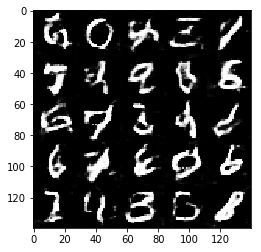

Batch: 1101 - Discriminator Loss: 0.721831202507019 - Generator Loss: 2.173090934753418
Batch: 1102 - Discriminator Loss: 0.742131233215332 - Generator Loss: 1.5152992010116577
Batch: 1103 - Discriminator Loss: 1.0009567737579346 - Generator Loss: 3.202582836151123
Batch: 1104 - Discriminator Loss: 1.084641695022583 - Generator Loss: 1.019681692123413
Batch: 1105 - Discriminator Loss: 1.1860556602478027 - Generator Loss: 3.7485599517822266
Batch: 1106 - Discriminator Loss: 0.8941439986228943 - Generator Loss: 1.2786674499511719
Batch: 1107 - Discriminator Loss: 0.6714099645614624 - Generator Loss: 2.615004777908325
Batch: 1108 - Discriminator Loss: 0.6247351169586182 - Generator Loss: 2.408414840698242
Batch: 1109 - Discriminator Loss: 0.7365850210189819 - Generator Loss: 2.1881701946258545
Batch: 1110 - Discriminator Loss: 0.8479530811309814 - Generator Loss: 1.5294710397720337
Batch: 1111 - Discriminator Loss: 0.9302424192428589 - Generator Loss: 3.4424614906311035
Batch: 1112 - Disc

Batch: 1193 - Discriminator Loss: 0.7695162892341614 - Generator Loss: 1.497497797012329
Batch: 1194 - Discriminator Loss: 0.7171562314033508 - Generator Loss: 2.5084877014160156
Batch: 1195 - Discriminator Loss: 0.6783671379089355 - Generator Loss: 2.21246337890625
Batch: 1196 - Discriminator Loss: 0.707716703414917 - Generator Loss: 2.517426013946533
Batch: 1197 - Discriminator Loss: 0.8115113377571106 - Generator Loss: 2.2247447967529297
Batch: 1198 - Discriminator Loss: 0.6820816397666931 - Generator Loss: 1.677526831626892
Batch: 1199 - Discriminator Loss: 0.7198032140731812 - Generator Loss: 3.2565553188323975
Batch: 1200 - Discriminator Loss: 0.9317788481712341 - Generator Loss: 0.9165844917297363


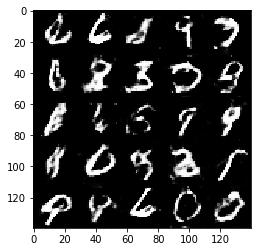

Batch: 1201 - Discriminator Loss: 1.1503362655639648 - Generator Loss: 4.268577575683594
Batch: 1202 - Discriminator Loss: 0.8617646098136902 - Generator Loss: 1.7133607864379883
Batch: 1203 - Discriminator Loss: 0.7034900188446045 - Generator Loss: 1.9635825157165527
Batch: 1204 - Discriminator Loss: 0.626644492149353 - Generator Loss: 2.590204954147339
Batch: 1205 - Discriminator Loss: 0.7426373958587646 - Generator Loss: 1.9182236194610596
Batch: 1206 - Discriminator Loss: 0.617195725440979 - Generator Loss: 2.182541608810425
Batch: 1207 - Discriminator Loss: 0.6011028289794922 - Generator Loss: 2.6332039833068848
Batch: 1208 - Discriminator Loss: 0.7200900316238403 - Generator Loss: 1.6781792640686035
Batch: 1209 - Discriminator Loss: 0.8869870901107788 - Generator Loss: 3.6570169925689697
Batch: 1210 - Discriminator Loss: 1.2085182666778564 - Generator Loss: 0.7145757675170898
Batch: 1211 - Discriminator Loss: 1.2098627090454102 - Generator Loss: 4.659576416015625
Batch: 1212 - Di

Batch: 1293 - Discriminator Loss: 0.5793353915214539 - Generator Loss: 2.4608235359191895
Batch: 1294 - Discriminator Loss: 0.7202897071838379 - Generator Loss: 1.7106478214263916
Batch: 1295 - Discriminator Loss: 0.785498857498169 - Generator Loss: 3.452209234237671
Batch: 1296 - Discriminator Loss: 0.9996892809867859 - Generator Loss: 1.3253945112228394
Batch: 1297 - Discriminator Loss: 1.026623249053955 - Generator Loss: 5.16796350479126
Batch: 1298 - Discriminator Loss: 1.8559528589248657 - Generator Loss: 0.862359881401062
Batch: 1299 - Discriminator Loss: 1.9756474494934082 - Generator Loss: 4.746034622192383
Batch: 1300 - Discriminator Loss: 2.0701401233673096 - Generator Loss: 0.7197595834732056


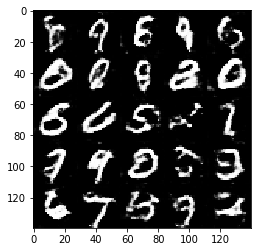

Batch: 1301 - Discriminator Loss: 1.2542943954467773 - Generator Loss: 2.995314598083496
Batch: 1302 - Discriminator Loss: 1.2242841720581055 - Generator Loss: 1.248167872428894
Batch: 1303 - Discriminator Loss: 0.8377053737640381 - Generator Loss: 2.0259387493133545
Batch: 1304 - Discriminator Loss: 0.9048012495040894 - Generator Loss: 2.3375651836395264
Batch: 1305 - Discriminator Loss: 1.0995539426803589 - Generator Loss: 1.009122610092163
Batch: 1306 - Discriminator Loss: 1.3571072816848755 - Generator Loss: 3.740344524383545
Batch: 1307 - Discriminator Loss: 1.31523597240448 - Generator Loss: 1.307319164276123
Batch: 1308 - Discriminator Loss: 1.2201402187347412 - Generator Loss: 4.189980506896973
Batch: 1309 - Discriminator Loss: 1.88899827003479 - Generator Loss: 0.874913215637207
Batch: 1310 - Discriminator Loss: 1.8022656440734863 - Generator Loss: 5.021498203277588
Batch: 1311 - Discriminator Loss: 2.580897092819214 - Generator Loss: 0.8692308068275452
Batch: 1312 - Discrimin

Batch: 1393 - Discriminator Loss: 2.1747868061065674 - Generator Loss: 1.0762633085250854
Batch: 1394 - Discriminator Loss: 1.0695459842681885 - Generator Loss: 2.6540019512176514
Batch: 1395 - Discriminator Loss: 1.5191513299942017 - Generator Loss: 0.5605047345161438
Batch: 1396 - Discriminator Loss: 2.150973320007324 - Generator Loss: 4.051302433013916
Batch: 1397 - Discriminator Loss: 1.7822128534317017 - Generator Loss: 0.9916689991950989
Batch: 1398 - Discriminator Loss: 1.2289893627166748 - Generator Loss: 2.2878799438476562
Batch: 1399 - Discriminator Loss: 0.9623229503631592 - Generator Loss: 1.420583963394165
Batch: 1400 - Discriminator Loss: 0.9099141359329224 - Generator Loss: 2.6527671813964844


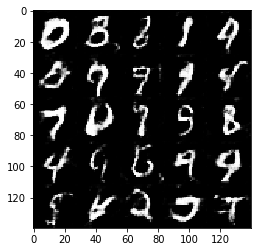

Batch: 1401 - Discriminator Loss: 1.02581787109375 - Generator Loss: 1.1683523654937744
Batch: 1402 - Discriminator Loss: 1.0659369230270386 - Generator Loss: 3.573268175125122
Batch: 1403 - Discriminator Loss: 1.0325417518615723 - Generator Loss: 1.2876474857330322
Batch: 1404 - Discriminator Loss: 1.0289655923843384 - Generator Loss: 4.133965492248535
Batch: 1405 - Discriminator Loss: 1.0896227359771729 - Generator Loss: 1.4675908088684082
Batch: 1406 - Discriminator Loss: 0.8515435457229614 - Generator Loss: 2.6898016929626465
Batch: 1407 - Discriminator Loss: 0.8275719285011292 - Generator Loss: 1.492265224456787
Batch: 1408 - Discriminator Loss: 0.8244459629058838 - Generator Loss: 3.1081323623657227
Batch: 1409 - Discriminator Loss: 0.7690930962562561 - Generator Loss: 1.6306734085083008
Batch: 1410 - Discriminator Loss: 0.6790391206741333 - Generator Loss: 2.459862232208252
Batch: 1411 - Discriminator Loss: 0.596887469291687 - Generator Loss: 2.3966922760009766
Batch: 1412 - Dis

Batch: 1493 - Discriminator Loss: 0.49834805727005005 - Generator Loss: 2.8473963737487793
Batch: 1494 - Discriminator Loss: 0.618426501750946 - Generator Loss: 2.7775115966796875
Batch: 1495 - Discriminator Loss: 0.5133845806121826 - Generator Loss: 2.5236778259277344
Batch: 1496 - Discriminator Loss: 0.5027459859848022 - Generator Loss: 2.7871036529541016
Batch: 1497 - Discriminator Loss: 0.6145933866500854 - Generator Loss: 3.4401285648345947
Batch: 1498 - Discriminator Loss: 0.6581162214279175 - Generator Loss: 2.0878968238830566
Batch: 1499 - Discriminator Loss: 0.5889778733253479 - Generator Loss: 3.2660348415374756
Batch: 1500 - Discriminator Loss: 0.5824812650680542 - Generator Loss: 1.978111982345581


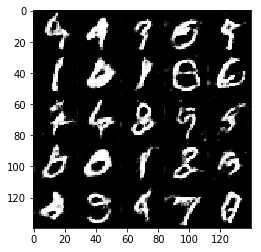

Batch: 1501 - Discriminator Loss: 0.7248077392578125 - Generator Loss: 3.3370518684387207
Batch: 1502 - Discriminator Loss: 0.6728836297988892 - Generator Loss: 1.7026398181915283
Batch: 1503 - Discriminator Loss: 0.6445844173431396 - Generator Loss: 2.373889207839966
Batch: 1504 - Discriminator Loss: 0.6738111972808838 - Generator Loss: 4.625761032104492
Batch: 1505 - Discriminator Loss: 1.193956971168518 - Generator Loss: 0.5155726075172424
Batch: 1506 - Discriminator Loss: 2.0057120323181152 - Generator Loss: 6.790515899658203
Batch: 1507 - Discriminator Loss: 3.7240867614746094 - Generator Loss: 1.9314053058624268
Batch: 1508 - Discriminator Loss: 1.1043362617492676 - Generator Loss: 1.8630000352859497
Batch: 1509 - Discriminator Loss: 0.9193928241729736 - Generator Loss: 3.0660552978515625
Batch: 1510 - Discriminator Loss: 0.76949143409729 - Generator Loss: 1.8330717086791992
Batch: 1511 - Discriminator Loss: 0.7544968128204346 - Generator Loss: 1.6783702373504639
Batch: 1512 - Di

Batch: 1593 - Discriminator Loss: 1.4160488843917847 - Generator Loss: 3.424306869506836
Batch: 1594 - Discriminator Loss: 1.6985228061676025 - Generator Loss: 0.6821261644363403
Batch: 1595 - Discriminator Loss: 1.6448923349380493 - Generator Loss: 3.7563765048980713
Batch: 1596 - Discriminator Loss: 1.316051959991455 - Generator Loss: 1.0975134372711182
Batch: 1597 - Discriminator Loss: 1.0117193460464478 - Generator Loss: 2.63397216796875
Batch: 1598 - Discriminator Loss: 0.9517180323600769 - Generator Loss: 1.2625386714935303
Batch: 1599 - Discriminator Loss: 0.9010794162750244 - Generator Loss: 2.7648658752441406
Batch: 1600 - Discriminator Loss: 0.9161332845687866 - Generator Loss: 1.564068078994751


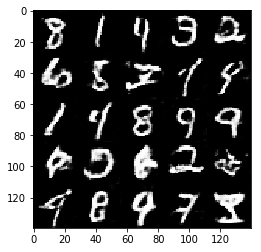

Batch: 1601 - Discriminator Loss: 0.7416658401489258 - Generator Loss: 2.646777391433716
Batch: 1602 - Discriminator Loss: 0.7674797773361206 - Generator Loss: 1.802710771560669
Batch: 1603 - Discriminator Loss: 0.7550880312919617 - Generator Loss: 2.897895574569702
Batch: 1604 - Discriminator Loss: 0.6426286101341248 - Generator Loss: 1.917473554611206
Batch: 1605 - Discriminator Loss: 0.8798626661300659 - Generator Loss: 3.9058430194854736
Batch: 1606 - Discriminator Loss: 1.3055859804153442 - Generator Loss: 0.8440932035446167
Batch: 1607 - Discriminator Loss: 1.2205371856689453 - Generator Loss: 3.531078815460205
Batch: 1608 - Discriminator Loss: 1.3049743175506592 - Generator Loss: 0.9223867654800415
Batch: 1609 - Discriminator Loss: 1.3259894847869873 - Generator Loss: 3.383512496948242
Batch: 1610 - Discriminator Loss: 1.2270363569259644 - Generator Loss: 1.0351084470748901
Batch: 1611 - Discriminator Loss: 1.007681131362915 - Generator Loss: 2.9658308029174805
Batch: 1612 - Dis

Batch: 1693 - Discriminator Loss: 1.2684016227722168 - Generator Loss: 2.4872541427612305
Batch: 1694 - Discriminator Loss: 1.2516529560089111 - Generator Loss: 0.9259072542190552
Batch: 1695 - Discriminator Loss: 1.4779417514801025 - Generator Loss: 3.088423490524292
Batch: 1696 - Discriminator Loss: 1.2508705854415894 - Generator Loss: 1.0426180362701416
Batch: 1697 - Discriminator Loss: 0.9573482871055603 - Generator Loss: 2.563722610473633
Batch: 1698 - Discriminator Loss: 1.0247769355773926 - Generator Loss: 1.287078619003296
Batch: 1699 - Discriminator Loss: 0.8878989219665527 - Generator Loss: 1.8485465049743652
Batch: 1700 - Discriminator Loss: 0.960008442401886 - Generator Loss: 1.3736902475357056


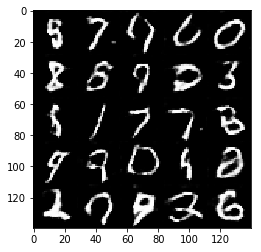

Batch: 1701 - Discriminator Loss: 1.172308087348938 - Generator Loss: 2.1926584243774414
Batch: 1702 - Discriminator Loss: 1.1644765138626099 - Generator Loss: 0.8693646192550659
Batch: 1703 - Discriminator Loss: 1.4047404527664185 - Generator Loss: 3.333242416381836
Batch: 1704 - Discriminator Loss: 1.03131103515625 - Generator Loss: 1.3791444301605225
Batch: 1705 - Discriminator Loss: 0.8826141357421875 - Generator Loss: 1.969478964805603
Batch: 1706 - Discriminator Loss: 0.6982083320617676 - Generator Loss: 1.982771873474121
Batch: 1707 - Discriminator Loss: 0.8801904916763306 - Generator Loss: 2.211264133453369
Batch: 1708 - Discriminator Loss: 0.674814760684967 - Generator Loss: 1.9519779682159424
Batch: 1709 - Discriminator Loss: 0.7429606318473816 - Generator Loss: 3.1489992141723633
Batch: 1710 - Discriminator Loss: 0.8125530481338501 - Generator Loss: 1.213600754737854
Batch: 1711 - Discriminator Loss: 0.9123832583427429 - Generator Loss: 3.865216016769409
Batch: 1712 - Discri

Batch: 1793 - Discriminator Loss: 0.550322413444519 - Generator Loss: 2.495490074157715
Batch: 1794 - Discriminator Loss: 0.5894231796264648 - Generator Loss: 2.2604072093963623
Batch: 1795 - Discriminator Loss: 0.6063756346702576 - Generator Loss: 2.711735248565674
Batch: 1796 - Discriminator Loss: 0.6119223833084106 - Generator Loss: 3.839395523071289
Batch: 1797 - Discriminator Loss: 0.9453823566436768 - Generator Loss: 1.2444438934326172
Batch: 1798 - Discriminator Loss: 0.8956300020217896 - Generator Loss: 6.1619462966918945
Batch: 1799 - Discriminator Loss: 2.0615360736846924 - Generator Loss: 0.5498842000961304
Batch: 1800 - Discriminator Loss: 1.7511699199676514 - Generator Loss: 4.770864009857178


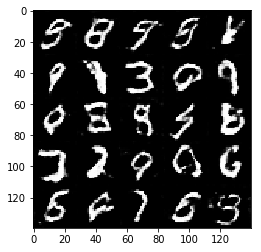

Batch: 1801 - Discriminator Loss: 2.3509693145751953 - Generator Loss: 0.8095738887786865
Batch: 1802 - Discriminator Loss: 1.5170916318893433 - Generator Loss: 3.213620185852051
Batch: 1803 - Discriminator Loss: 1.0885539054870605 - Generator Loss: 1.381103515625
Batch: 1804 - Discriminator Loss: 0.9922318458557129 - Generator Loss: 2.156527519226074
Batch: 1805 - Discriminator Loss: 0.9147982597351074 - Generator Loss: 1.106459379196167
Batch: 1806 - Discriminator Loss: 0.8451309204101562 - Generator Loss: 2.621044158935547
Batch: 1807 - Discriminator Loss: 0.9185147285461426 - Generator Loss: 1.3833584785461426
Batch: 1808 - Discriminator Loss: 0.9601409435272217 - Generator Loss: 2.2525572776794434
Batch: 1809 - Discriminator Loss: 0.9347734451293945 - Generator Loss: 1.4355976581573486
Batch: 1810 - Discriminator Loss: 0.8673122525215149 - Generator Loss: 2.51121187210083
Batch: 1811 - Discriminator Loss: 0.6938508152961731 - Generator Loss: 1.8867796659469604
Batch: 1812 - Discri

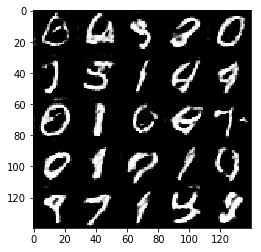

Batch: 1 - Discriminator Loss: 1.8166582584381104 - Generator Loss: 5.324329376220703
Batch: 2 - Discriminator Loss: 1.8100320100784302 - Generator Loss: 1.0056354999542236
Batch: 3 - Discriminator Loss: 1.0789533853530884 - Generator Loss: 3.2470264434814453
Batch: 4 - Discriminator Loss: 0.7410608530044556 - Generator Loss: 2.468090772628784
Batch: 5 - Discriminator Loss: 0.6841733455657959 - Generator Loss: 1.8878037929534912
Batch: 6 - Discriminator Loss: 0.7841110229492188 - Generator Loss: 2.620410442352295
Batch: 7 - Discriminator Loss: 0.7726950645446777 - Generator Loss: 2.4301886558532715
Batch: 8 - Discriminator Loss: 0.6865637302398682 - Generator Loss: 2.333696126937866
Batch: 9 - Discriminator Loss: 0.586661696434021 - Generator Loss: 3.5254924297332764
Batch: 10 - Discriminator Loss: 0.608863353729248 - Generator Loss: 1.8937466144561768
Batch: 11 - Discriminator Loss: 0.5773671865463257 - Generator Loss: 3.438851833343506
Batch: 12 - Discriminator Loss: 0.60474848747253

Batch: 95 - Discriminator Loss: 0.5844916105270386 - Generator Loss: 3.1453094482421875
Batch: 96 - Discriminator Loss: 0.6841415762901306 - Generator Loss: 1.8090856075286865
Batch: 97 - Discriminator Loss: 0.8519216179847717 - Generator Loss: 4.334984302520752
Batch: 98 - Discriminator Loss: 1.0472967624664307 - Generator Loss: 1.1662354469299316
Batch: 99 - Discriminator Loss: 0.7097415924072266 - Generator Loss: 2.311095952987671
Batch: 100 - Discriminator Loss: 0.6565686464309692 - Generator Loss: 2.83808970451355


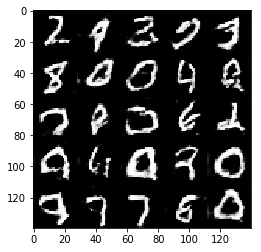

Batch: 101 - Discriminator Loss: 0.7371072769165039 - Generator Loss: 1.66402268409729
Batch: 102 - Discriminator Loss: 0.8536361455917358 - Generator Loss: 3.811849594116211
Batch: 103 - Discriminator Loss: 1.0139398574829102 - Generator Loss: 1.3787463903427124
Batch: 104 - Discriminator Loss: 0.9343113899230957 - Generator Loss: 3.7082314491271973
Batch: 105 - Discriminator Loss: 0.7507199645042419 - Generator Loss: 1.758119821548462
Batch: 106 - Discriminator Loss: 0.8550176620483398 - Generator Loss: 3.9061343669891357
Batch: 107 - Discriminator Loss: 1.2786728143692017 - Generator Loss: 1.1208088397979736
Batch: 108 - Discriminator Loss: 1.112751841545105 - Generator Loss: 4.508705139160156
Batch: 109 - Discriminator Loss: 1.077793002128601 - Generator Loss: 1.0107567310333252
Batch: 110 - Discriminator Loss: 1.577789545059204 - Generator Loss: 5.287347793579102
Batch: 111 - Discriminator Loss: 1.9044214487075806 - Generator Loss: 0.9576382637023926
Batch: 112 - Discriminator Los

Batch: 194 - Discriminator Loss: 0.7046993970870972 - Generator Loss: 2.9491312503814697
Batch: 195 - Discriminator Loss: 0.6233845949172974 - Generator Loss: 1.9639222621917725
Batch: 196 - Discriminator Loss: 0.6237770318984985 - Generator Loss: 4.1778130531311035
Batch: 197 - Discriminator Loss: 0.585407018661499 - Generator Loss: 2.065237045288086
Batch: 198 - Discriminator Loss: 0.4401484727859497 - Generator Loss: 2.9090404510498047
Batch: 199 - Discriminator Loss: 0.5375064611434937 - Generator Loss: 3.0536155700683594
Batch: 200 - Discriminator Loss: 0.5382717847824097 - Generator Loss: 2.733720302581787


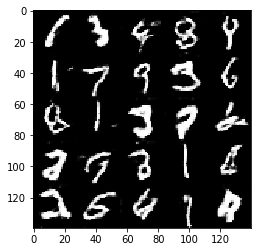

Batch: 201 - Discriminator Loss: 0.4436578154563904 - Generator Loss: 3.1157665252685547
Batch: 202 - Discriminator Loss: 0.4815920889377594 - Generator Loss: 2.985778331756592
Batch: 203 - Discriminator Loss: 0.5000107884407043 - Generator Loss: 2.777216911315918
Batch: 204 - Discriminator Loss: 0.4925905466079712 - Generator Loss: 3.2666854858398438
Batch: 205 - Discriminator Loss: 0.475190669298172 - Generator Loss: 3.519669532775879
Batch: 206 - Discriminator Loss: 0.6342708468437195 - Generator Loss: 1.8649790287017822
Batch: 207 - Discriminator Loss: 0.5683518052101135 - Generator Loss: 4.031799793243408
Batch: 208 - Discriminator Loss: 0.8186589479446411 - Generator Loss: 2.002903938293457
Batch: 209 - Discriminator Loss: 0.6671530604362488 - Generator Loss: 5.46019172668457
Batch: 210 - Discriminator Loss: 2.2458832263946533 - Generator Loss: 0.41324400901794434
Batch: 211 - Discriminator Loss: 3.7044477462768555 - Generator Loss: 6.419756889343262
Batch: 212 - Discriminator Lo

Batch: 294 - Discriminator Loss: 0.7406204342842102 - Generator Loss: 1.367832899093628
Batch: 295 - Discriminator Loss: 0.6077651977539062 - Generator Loss: 3.4691715240478516
Batch: 296 - Discriminator Loss: 0.5784803628921509 - Generator Loss: 2.1423516273498535
Batch: 297 - Discriminator Loss: 0.6491590142250061 - Generator Loss: 3.4996917247772217
Batch: 298 - Discriminator Loss: 0.5567392706871033 - Generator Loss: 2.445098876953125
Batch: 299 - Discriminator Loss: 0.5513159036636353 - Generator Loss: 2.5547118186950684
Batch: 300 - Discriminator Loss: 0.6133551597595215 - Generator Loss: 2.926522731781006


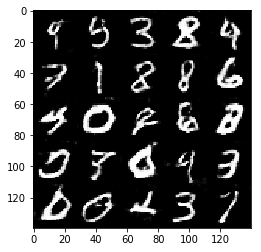

Batch: 301 - Discriminator Loss: 0.6103594303131104 - Generator Loss: 2.087087631225586
Batch: 302 - Discriminator Loss: 0.5901080965995789 - Generator Loss: 2.909247398376465
Batch: 303 - Discriminator Loss: 0.48750606179237366 - Generator Loss: 3.3246517181396484
Batch: 304 - Discriminator Loss: 0.5819367170333862 - Generator Loss: 2.133479595184326
Batch: 305 - Discriminator Loss: 0.6783508658409119 - Generator Loss: 2.9996485710144043
Batch: 306 - Discriminator Loss: 0.5516092777252197 - Generator Loss: 2.2048230171203613
Batch: 307 - Discriminator Loss: 0.7452516555786133 - Generator Loss: 4.514096260070801
Batch: 308 - Discriminator Loss: 0.6381666660308838 - Generator Loss: 2.2233402729034424
Batch: 309 - Discriminator Loss: 0.6091723442077637 - Generator Loss: 2.177429676055908
Batch: 310 - Discriminator Loss: 0.5587465763092041 - Generator Loss: 3.2218399047851562
Batch: 311 - Discriminator Loss: 0.5967671275138855 - Generator Loss: 2.1065592765808105
Batch: 312 - Discriminato

Batch: 394 - Discriminator Loss: 0.92490553855896 - Generator Loss: 1.3504281044006348
Batch: 395 - Discriminator Loss: 1.175597906112671 - Generator Loss: 5.000900745391846
Batch: 396 - Discriminator Loss: 1.536648154258728 - Generator Loss: 1.493873119354248
Batch: 397 - Discriminator Loss: 0.993780255317688 - Generator Loss: 2.9757628440856934
Batch: 398 - Discriminator Loss: 1.096655011177063 - Generator Loss: 1.0092155933380127
Batch: 399 - Discriminator Loss: 1.2216005325317383 - Generator Loss: 3.2867281436920166
Batch: 400 - Discriminator Loss: 1.3040502071380615 - Generator Loss: 0.9377621412277222


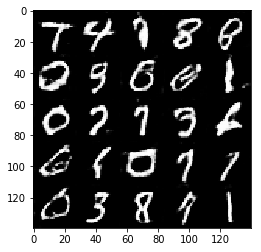

Batch: 401 - Discriminator Loss: 1.3503222465515137 - Generator Loss: 3.8406896591186523
Batch: 402 - Discriminator Loss: 1.2725322246551514 - Generator Loss: 0.9790756702423096
Batch: 403 - Discriminator Loss: 0.8214402794837952 - Generator Loss: 2.8320019245147705
Batch: 404 - Discriminator Loss: 0.9589884281158447 - Generator Loss: 1.2775485515594482
Batch: 405 - Discriminator Loss: 0.9549939632415771 - Generator Loss: 3.127528190612793
Batch: 406 - Discriminator Loss: 0.618152916431427 - Generator Loss: 2.3061323165893555
Batch: 407 - Discriminator Loss: 0.6844022274017334 - Generator Loss: 2.5896127223968506
Batch: 408 - Discriminator Loss: 0.717415452003479 - Generator Loss: 1.9302932024002075
Batch: 409 - Discriminator Loss: 0.718869149684906 - Generator Loss: 3.3360233306884766
Batch: 410 - Discriminator Loss: 0.9291952848434448 - Generator Loss: 1.3330764770507812
Batch: 411 - Discriminator Loss: 0.7229205369949341 - Generator Loss: 3.5359373092651367
Batch: 412 - Discriminato

Batch: 494 - Discriminator Loss: 1.0649216175079346 - Generator Loss: 5.17015266418457
Batch: 495 - Discriminator Loss: 1.8353016376495361 - Generator Loss: 1.2880911827087402
Batch: 496 - Discriminator Loss: 0.9375733137130737 - Generator Loss: 3.5633764266967773
Batch: 497 - Discriminator Loss: 1.4626034498214722 - Generator Loss: 0.5817676782608032
Batch: 498 - Discriminator Loss: 1.8328572511672974 - Generator Loss: 4.854339599609375
Batch: 499 - Discriminator Loss: 1.88373863697052 - Generator Loss: 0.7745388150215149
Batch: 500 - Discriminator Loss: 1.4463410377502441 - Generator Loss: 3.3255553245544434


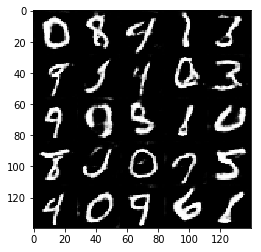

Batch: 501 - Discriminator Loss: 1.2595850229263306 - Generator Loss: 1.065770149230957
Batch: 502 - Discriminator Loss: 1.2098641395568848 - Generator Loss: 2.1113829612731934
Batch: 503 - Discriminator Loss: 0.8133230805397034 - Generator Loss: 2.8176474571228027
Batch: 504 - Discriminator Loss: 0.8245885372161865 - Generator Loss: 1.592862844467163
Batch: 505 - Discriminator Loss: 0.7193917632102966 - Generator Loss: 2.5834858417510986
Batch: 506 - Discriminator Loss: 0.8025959730148315 - Generator Loss: 2.6465187072753906
Batch: 507 - Discriminator Loss: 0.9773247241973877 - Generator Loss: 1.1205520629882812
Batch: 508 - Discriminator Loss: 1.0261412858963013 - Generator Loss: 3.2772216796875
Batch: 509 - Discriminator Loss: 0.7319126129150391 - Generator Loss: 1.7212988138198853
Batch: 510 - Discriminator Loss: 0.675451397895813 - Generator Loss: 2.63156795501709
Batch: 511 - Discriminator Loss: 0.7007634043693542 - Generator Loss: 2.065171241760254
Batch: 512 - Discriminator Los

Batch: 594 - Discriminator Loss: 0.6079459190368652 - Generator Loss: 2.269122838973999
Batch: 595 - Discriminator Loss: 0.6204633712768555 - Generator Loss: 2.9442431926727295
Batch: 596 - Discriminator Loss: 0.5171670317649841 - Generator Loss: 2.3854007720947266
Batch: 597 - Discriminator Loss: 0.495649516582489 - Generator Loss: 2.710963249206543
Batch: 598 - Discriminator Loss: 0.7082528471946716 - Generator Loss: 2.7682366371154785
Batch: 599 - Discriminator Loss: 0.7183969020843506 - Generator Loss: 3.4402689933776855
Batch: 600 - Discriminator Loss: 0.6333518028259277 - Generator Loss: 1.9711922407150269


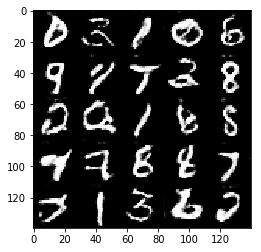

Batch: 601 - Discriminator Loss: 0.7257034778594971 - Generator Loss: 2.6057639122009277
Batch: 602 - Discriminator Loss: 0.641461968421936 - Generator Loss: 3.580516815185547
Batch: 603 - Discriminator Loss: 0.8696542978286743 - Generator Loss: 1.2385179996490479
Batch: 604 - Discriminator Loss: 0.8451275825500488 - Generator Loss: 4.6531171798706055
Batch: 605 - Discriminator Loss: 0.6960229873657227 - Generator Loss: 1.904738187789917
Batch: 606 - Discriminator Loss: 0.5312156677246094 - Generator Loss: 2.5223398208618164
Batch: 607 - Discriminator Loss: 0.5197627544403076 - Generator Loss: 3.4776954650878906
Batch: 608 - Discriminator Loss: 0.5179981589317322 - Generator Loss: 2.793830394744873
Batch: 609 - Discriminator Loss: 0.5002623796463013 - Generator Loss: 2.6939034461975098
Batch: 610 - Discriminator Loss: 0.5137521028518677 - Generator Loss: 3.0290212631225586
Batch: 611 - Discriminator Loss: 0.5454341173171997 - Generator Loss: 2.240241527557373
Batch: 612 - Discriminator

Batch: 694 - Discriminator Loss: 0.8098801374435425 - Generator Loss: 5.215030670166016
Batch: 695 - Discriminator Loss: 1.092673420906067 - Generator Loss: 1.6507240533828735
Batch: 696 - Discriminator Loss: 1.0114601850509644 - Generator Loss: 4.478170394897461
Batch: 697 - Discriminator Loss: 1.2200394868850708 - Generator Loss: 1.0335801839828491
Batch: 698 - Discriminator Loss: 1.3593931198120117 - Generator Loss: 4.4317626953125
Batch: 699 - Discriminator Loss: 1.0524741411209106 - Generator Loss: 1.326941967010498
Batch: 700 - Discriminator Loss: 0.8621553182601929 - Generator Loss: 3.57470703125


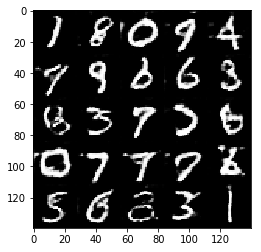

Batch: 701 - Discriminator Loss: 1.0034819841384888 - Generator Loss: 1.2525324821472168
Batch: 702 - Discriminator Loss: 0.9616267085075378 - Generator Loss: 3.7995834350585938
Batch: 703 - Discriminator Loss: 0.45541566610336304 - Generator Loss: 3.515207529067993
Batch: 704 - Discriminator Loss: 0.758349597454071 - Generator Loss: 1.6002118587493896
Batch: 705 - Discriminator Loss: 0.7661986947059631 - Generator Loss: 3.617387294769287
Batch: 706 - Discriminator Loss: 0.8704273104667664 - Generator Loss: 1.419640302658081
Batch: 707 - Discriminator Loss: 1.1416054964065552 - Generator Loss: 6.158178329467773
Batch: 708 - Discriminator Loss: 1.1105482578277588 - Generator Loss: 2.096831798553467
Batch: 709 - Discriminator Loss: 0.5700231194496155 - Generator Loss: 2.9990572929382324
Batch: 710 - Discriminator Loss: 0.5108353495597839 - Generator Loss: 2.9840455055236816
Batch: 711 - Discriminator Loss: 0.5629109144210815 - Generator Loss: 2.3659276962280273
Batch: 712 - Discriminator

Batch: 794 - Discriminator Loss: 0.5555187463760376 - Generator Loss: 3.0876948833465576
Batch: 795 - Discriminator Loss: 0.546087384223938 - Generator Loss: 3.007411479949951
Batch: 796 - Discriminator Loss: 0.6645309329032898 - Generator Loss: 2.5748467445373535
Batch: 797 - Discriminator Loss: 0.42268872261047363 - Generator Loss: 3.2450923919677734
Batch: 798 - Discriminator Loss: 0.6077830791473389 - Generator Loss: 1.8266865015029907
Batch: 799 - Discriminator Loss: 0.9738581776618958 - Generator Loss: 6.352766990661621
Batch: 800 - Discriminator Loss: 1.3491768836975098 - Generator Loss: 1.674150824546814


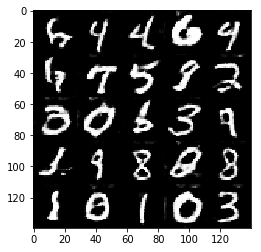

Batch: 801 - Discriminator Loss: 0.822009801864624 - Generator Loss: 3.591325283050537
Batch: 802 - Discriminator Loss: 1.227076530456543 - Generator Loss: 0.5764154195785522
Batch: 803 - Discriminator Loss: 1.573760747909546 - Generator Loss: 5.53762149810791
Batch: 804 - Discriminator Loss: 1.8041918277740479 - Generator Loss: 0.9418367743492126
Batch: 805 - Discriminator Loss: 1.2903474569320679 - Generator Loss: 4.221322059631348
Batch: 806 - Discriminator Loss: 1.4826374053955078 - Generator Loss: 0.8698331713676453
Batch: 807 - Discriminator Loss: 1.2858967781066895 - Generator Loss: 3.4910683631896973
Batch: 808 - Discriminator Loss: 0.743031919002533 - Generator Loss: 2.696667194366455
Batch: 809 - Discriminator Loss: 0.6982788443565369 - Generator Loss: 3.03544020652771
Batch: 810 - Discriminator Loss: 0.6046726703643799 - Generator Loss: 2.28920841217041
Batch: 811 - Discriminator Loss: 0.6270039677619934 - Generator Loss: 2.0328822135925293
Batch: 812 - Discriminator Loss: 1

Batch: 894 - Discriminator Loss: 1.135302186012268 - Generator Loss: 5.232905387878418
Batch: 895 - Discriminator Loss: 1.4996886253356934 - Generator Loss: 1.2662299871444702
Batch: 896 - Discriminator Loss: 0.9223788380622864 - Generator Loss: 5.709136962890625
Batch: 897 - Discriminator Loss: 1.307992696762085 - Generator Loss: 0.5478223562240601
Batch: 898 - Discriminator Loss: 1.2303460836410522 - Generator Loss: 4.368502140045166
Batch: 899 - Discriminator Loss: 0.7591105103492737 - Generator Loss: 2.0600857734680176
Batch: 900 - Discriminator Loss: 0.6355281472206116 - Generator Loss: 2.3840036392211914


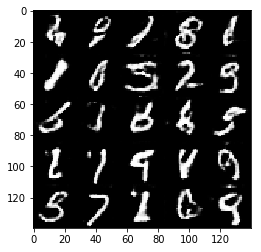

Batch: 901 - Discriminator Loss: 0.5997596979141235 - Generator Loss: 2.172118663787842
Batch: 902 - Discriminator Loss: 0.6284184455871582 - Generator Loss: 3.140078067779541
Batch: 903 - Discriminator Loss: 0.6265116930007935 - Generator Loss: 2.5803709030151367
Batch: 904 - Discriminator Loss: 0.5405638813972473 - Generator Loss: 3.216197967529297
Batch: 905 - Discriminator Loss: 0.9194043874740601 - Generator Loss: 1.3922111988067627
Batch: 906 - Discriminator Loss: 1.148952841758728 - Generator Loss: 6.114123821258545
Batch: 907 - Discriminator Loss: 1.2185977697372437 - Generator Loss: 1.8704098463058472
Batch: 908 - Discriminator Loss: 0.9664889574050903 - Generator Loss: 2.896334409713745
Batch: 909 - Discriminator Loss: 0.7774738669395447 - Generator Loss: 2.389380931854248
Batch: 910 - Discriminator Loss: 0.749690592288971 - Generator Loss: 2.792938709259033
Batch: 911 - Discriminator Loss: 0.6352932453155518 - Generator Loss: 2.1096739768981934
Batch: 912 - Discriminator Los

Batch: 994 - Discriminator Loss: 0.6671078205108643 - Generator Loss: 3.906965732574463
Batch: 995 - Discriminator Loss: 0.4839211702346802 - Generator Loss: 3.1636605262756348
Batch: 996 - Discriminator Loss: 0.5326645970344543 - Generator Loss: 2.6906754970550537
Batch: 997 - Discriminator Loss: 0.5112845301628113 - Generator Loss: 3.7145543098449707
Batch: 998 - Discriminator Loss: 0.47845062613487244 - Generator Loss: 2.92020845413208
Batch: 999 - Discriminator Loss: 0.47014519572257996 - Generator Loss: 2.674837827682495
Batch: 1000 - Discriminator Loss: 0.5476089715957642 - Generator Loss: 4.195925235748291


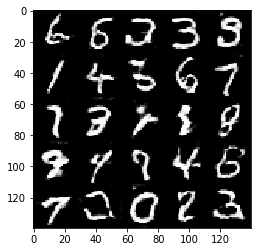

Batch: 1001 - Discriminator Loss: 0.5920132398605347 - Generator Loss: 2.090782403945923
Batch: 1002 - Discriminator Loss: 0.6247351765632629 - Generator Loss: 3.5995523929595947
Batch: 1003 - Discriminator Loss: 0.466419517993927 - Generator Loss: 3.430670738220215
Batch: 1004 - Discriminator Loss: 0.5387498736381531 - Generator Loss: 2.8104918003082275
Batch: 1005 - Discriminator Loss: 0.5051498413085938 - Generator Loss: 3.0787410736083984
Batch: 1006 - Discriminator Loss: 0.43528124690055847 - Generator Loss: 3.6395606994628906
Batch: 1007 - Discriminator Loss: 0.44096124172210693 - Generator Loss: 2.8432424068450928
Batch: 1008 - Discriminator Loss: 0.5337799787521362 - Generator Loss: 3.5615007877349854
Batch: 1009 - Discriminator Loss: 0.4440346956253052 - Generator Loss: 3.0038528442382812
Batch: 1010 - Discriminator Loss: 0.635574996471405 - Generator Loss: 1.7179148197174072
Batch: 1011 - Discriminator Loss: 0.6161402463912964 - Generator Loss: 3.998997211456299
Batch: 1012 -

Batch: 1093 - Discriminator Loss: 0.8466367721557617 - Generator Loss: 1.4140828847885132
Batch: 1094 - Discriminator Loss: 0.847730815410614 - Generator Loss: 3.8558435440063477
Batch: 1095 - Discriminator Loss: 0.8693853616714478 - Generator Loss: 1.5237276554107666
Batch: 1096 - Discriminator Loss: 0.681052565574646 - Generator Loss: 2.7961440086364746
Batch: 1097 - Discriminator Loss: 0.578898549079895 - Generator Loss: 3.5289838314056396
Batch: 1098 - Discriminator Loss: 0.8389472961425781 - Generator Loss: 1.3145769834518433
Batch: 1099 - Discriminator Loss: 0.8120505809783936 - Generator Loss: 3.5094897747039795
Batch: 1100 - Discriminator Loss: 0.6444600820541382 - Generator Loss: 2.819143295288086


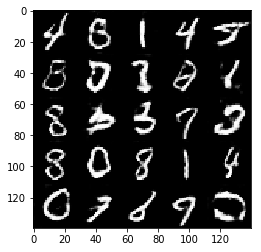

Batch: 1101 - Discriminator Loss: 0.7109845876693726 - Generator Loss: 2.142634391784668
Batch: 1102 - Discriminator Loss: 0.7055840492248535 - Generator Loss: 2.965888023376465
Batch: 1103 - Discriminator Loss: 0.5262773036956787 - Generator Loss: 2.825874090194702
Batch: 1104 - Discriminator Loss: 0.5564150214195251 - Generator Loss: 2.074493408203125
Batch: 1105 - Discriminator Loss: 0.7388545870780945 - Generator Loss: 3.788813591003418
Batch: 1106 - Discriminator Loss: 0.5514920949935913 - Generator Loss: 2.7157254219055176
Batch: 1107 - Discriminator Loss: 0.49237295985221863 - Generator Loss: 3.0578832626342773
Batch: 1108 - Discriminator Loss: 0.5393118858337402 - Generator Loss: 3.638728618621826
Batch: 1109 - Discriminator Loss: 0.8067829608917236 - Generator Loss: 1.3315173387527466
Batch: 1110 - Discriminator Loss: 0.960364580154419 - Generator Loss: 4.938605308532715
Batch: 1111 - Discriminator Loss: 0.99676513671875 - Generator Loss: 1.6979008913040161
Batch: 1112 - Discr

Batch: 1193 - Discriminator Loss: 0.43096843361854553 - Generator Loss: 3.341756820678711
Batch: 1194 - Discriminator Loss: 0.6580816507339478 - Generator Loss: 1.737226963043213
Batch: 1195 - Discriminator Loss: 1.4297258853912354 - Generator Loss: 7.415661811828613
Batch: 1196 - Discriminator Loss: 2.2226545810699463 - Generator Loss: 1.5180673599243164
Batch: 1197 - Discriminator Loss: 0.8839415311813354 - Generator Loss: 3.1810922622680664
Batch: 1198 - Discriminator Loss: 0.9463239312171936 - Generator Loss: 1.9747182130813599
Batch: 1199 - Discriminator Loss: 0.7534729838371277 - Generator Loss: 1.6169555187225342
Batch: 1200 - Discriminator Loss: 1.1250300407409668 - Generator Loss: 2.487778663635254


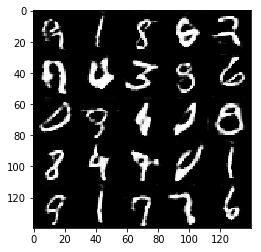

Batch: 1201 - Discriminator Loss: 0.8934416174888611 - Generator Loss: 1.1422958374023438
Batch: 1202 - Discriminator Loss: 1.1450062990188599 - Generator Loss: 4.616003036499023
Batch: 1203 - Discriminator Loss: 1.2659950256347656 - Generator Loss: 1.32576322555542
Batch: 1204 - Discriminator Loss: 1.2146499156951904 - Generator Loss: 5.220033645629883
Batch: 1205 - Discriminator Loss: 1.6040922403335571 - Generator Loss: 1.9588649272918701
Batch: 1206 - Discriminator Loss: 1.0381606817245483 - Generator Loss: 4.2554826736450195
Batch: 1207 - Discriminator Loss: 1.042365312576294 - Generator Loss: 0.7395319938659668
Batch: 1208 - Discriminator Loss: 1.6000206470489502 - Generator Loss: 5.391823768615723
Batch: 1209 - Discriminator Loss: 2.104689121246338 - Generator Loss: 0.9197724461555481
Batch: 1210 - Discriminator Loss: 0.9827868938446045 - Generator Loss: 3.0041332244873047
Batch: 1211 - Discriminator Loss: 0.7276875376701355 - Generator Loss: 2.2067198753356934
Batch: 1212 - Dis

Batch: 1293 - Discriminator Loss: 1.1382261514663696 - Generator Loss: 0.8547850847244263
Batch: 1294 - Discriminator Loss: 1.0609378814697266 - Generator Loss: 5.154589653015137
Batch: 1295 - Discriminator Loss: 1.0205928087234497 - Generator Loss: 1.9238321781158447
Batch: 1296 - Discriminator Loss: 0.7087951898574829 - Generator Loss: 3.1505913734436035
Batch: 1297 - Discriminator Loss: 0.6200141906738281 - Generator Loss: 5.231789588928223
Batch: 1298 - Discriminator Loss: 1.286759853363037 - Generator Loss: 1.0936105251312256
Batch: 1299 - Discriminator Loss: 1.0652132034301758 - Generator Loss: 4.090566635131836
Batch: 1300 - Discriminator Loss: 1.589521884918213 - Generator Loss: 0.8243343830108643


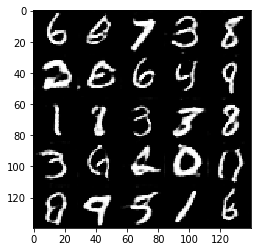

Batch: 1301 - Discriminator Loss: 2.1565167903900146 - Generator Loss: 4.777251243591309
Batch: 1302 - Discriminator Loss: 2.4756221771240234 - Generator Loss: 0.8047900795936584
Batch: 1303 - Discriminator Loss: 1.23629891872406 - Generator Loss: 3.038076877593994
Batch: 1304 - Discriminator Loss: 0.7276118993759155 - Generator Loss: 2.5842928886413574
Batch: 1305 - Discriminator Loss: 1.3136438131332397 - Generator Loss: 0.6952390670776367
Batch: 1306 - Discriminator Loss: 1.4560937881469727 - Generator Loss: 4.737524509429932
Batch: 1307 - Discriminator Loss: 1.2476853132247925 - Generator Loss: 1.306732416152954
Batch: 1308 - Discriminator Loss: 0.8106415271759033 - Generator Loss: 3.499351978302002
Batch: 1309 - Discriminator Loss: 0.6379580497741699 - Generator Loss: 2.413583517074585
Batch: 1310 - Discriminator Loss: 0.8042136430740356 - Generator Loss: 3.1035561561584473
Batch: 1311 - Discriminator Loss: 0.6046562790870667 - Generator Loss: 2.444230556488037
Batch: 1312 - Discr

Batch: 1393 - Discriminator Loss: 0.5087151527404785 - Generator Loss: 2.742182731628418
Batch: 1394 - Discriminator Loss: 0.44605305790901184 - Generator Loss: 3.4804916381835938
Batch: 1395 - Discriminator Loss: 0.48142221570014954 - Generator Loss: 3.5923445224761963
Batch: 1396 - Discriminator Loss: 0.6549336910247803 - Generator Loss: 1.933685541152954
Batch: 1397 - Discriminator Loss: 0.6853617429733276 - Generator Loss: 3.9731059074401855
Batch: 1398 - Discriminator Loss: 0.6622672080993652 - Generator Loss: 1.9574049711227417
Batch: 1399 - Discriminator Loss: 0.6749047040939331 - Generator Loss: 4.126120567321777
Batch: 1400 - Discriminator Loss: 0.918556809425354 - Generator Loss: 1.411913275718689


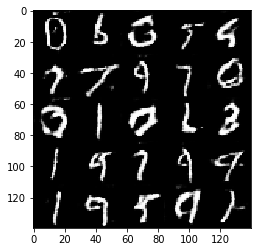

Batch: 1401 - Discriminator Loss: 0.7223557233810425 - Generator Loss: 3.8681955337524414
Batch: 1402 - Discriminator Loss: 0.9109240174293518 - Generator Loss: 1.3255199193954468
Batch: 1403 - Discriminator Loss: 0.865685224533081 - Generator Loss: 4.68419075012207
Batch: 1404 - Discriminator Loss: 0.8878376483917236 - Generator Loss: 1.2425812482833862
Batch: 1405 - Discriminator Loss: 1.2067080736160278 - Generator Loss: 5.586520195007324
Batch: 1406 - Discriminator Loss: 2.308661937713623 - Generator Loss: 0.9578085541725159
Batch: 1407 - Discriminator Loss: 1.3212542533874512 - Generator Loss: 4.688499927520752
Batch: 1408 - Discriminator Loss: 1.7494865655899048 - Generator Loss: 0.9453439712524414
Batch: 1409 - Discriminator Loss: 1.123335361480713 - Generator Loss: 3.9371657371520996
Batch: 1410 - Discriminator Loss: 0.5544164776802063 - Generator Loss: 2.678464412689209
Batch: 1411 - Discriminator Loss: 0.5138818621635437 - Generator Loss: 2.4983062744140625
Batch: 1412 - Disc

Batch: 1493 - Discriminator Loss: 0.5932696461677551 - Generator Loss: 2.439873218536377
Batch: 1494 - Discriminator Loss: 0.611345648765564 - Generator Loss: 3.5605673789978027
Batch: 1495 - Discriminator Loss: 0.4492962062358856 - Generator Loss: 3.3206334114074707
Batch: 1496 - Discriminator Loss: 0.6544146537780762 - Generator Loss: 1.870469570159912
Batch: 1497 - Discriminator Loss: 0.5845330953598022 - Generator Loss: 4.102343559265137
Batch: 1498 - Discriminator Loss: 0.5437310338020325 - Generator Loss: 3.0822083950042725
Batch: 1499 - Discriminator Loss: 0.5011049509048462 - Generator Loss: 2.6466195583343506
Batch: 1500 - Discriminator Loss: 0.5235337615013123 - Generator Loss: 3.023533582687378


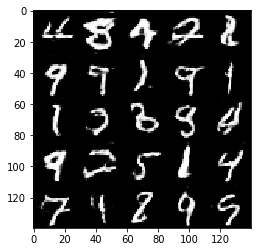

Batch: 1501 - Discriminator Loss: 0.5176732540130615 - Generator Loss: 2.437495231628418
Batch: 1502 - Discriminator Loss: 0.5099931955337524 - Generator Loss: 3.882300853729248
Batch: 1503 - Discriminator Loss: 0.592606246471405 - Generator Loss: 2.1647257804870605
Batch: 1504 - Discriminator Loss: 0.6656925678253174 - Generator Loss: 4.133106708526611
Batch: 1505 - Discriminator Loss: 0.4930412173271179 - Generator Loss: 2.6424736976623535
Batch: 1506 - Discriminator Loss: 0.5866583585739136 - Generator Loss: 2.5299935340881348
Batch: 1507 - Discriminator Loss: 0.4670940041542053 - Generator Loss: 3.285388469696045
Batch: 1508 - Discriminator Loss: 0.5692432522773743 - Generator Loss: 2.3498098850250244
Batch: 1509 - Discriminator Loss: 0.6110831499099731 - Generator Loss: 3.9111504554748535
Batch: 1510 - Discriminator Loss: 0.44590261578559875 - Generator Loss: 3.6947884559631348
Batch: 1511 - Discriminator Loss: 0.4807211756706238 - Generator Loss: 2.7919235229492188
Batch: 1512 - 

Batch: 1593 - Discriminator Loss: 0.4968341886997223 - Generator Loss: 2.8755745887756348
Batch: 1594 - Discriminator Loss: 0.4854772984981537 - Generator Loss: 2.440026044845581
Batch: 1595 - Discriminator Loss: 0.4815424680709839 - Generator Loss: 3.525282859802246
Batch: 1596 - Discriminator Loss: 0.44648224115371704 - Generator Loss: 3.1300086975097656
Batch: 1597 - Discriminator Loss: 0.47981080412864685 - Generator Loss: 3.435232162475586
Batch: 1598 - Discriminator Loss: 0.9351969957351685 - Generator Loss: 1.5517607927322388
Batch: 1599 - Discriminator Loss: 1.5393397808074951 - Generator Loss: 5.980306625366211
Batch: 1600 - Discriminator Loss: 2.1025736331939697 - Generator Loss: 0.9180744886398315


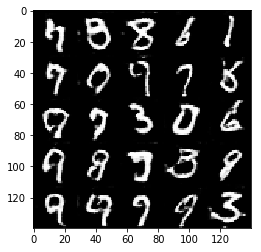

Batch: 1601 - Discriminator Loss: 1.2606405019760132 - Generator Loss: 3.6399312019348145
Batch: 1602 - Discriminator Loss: 0.8533458709716797 - Generator Loss: 2.0857553482055664
Batch: 1603 - Discriminator Loss: 0.7200257778167725 - Generator Loss: 1.774723768234253
Batch: 1604 - Discriminator Loss: 0.7872788310050964 - Generator Loss: 4.038228988647461
Batch: 1605 - Discriminator Loss: 0.6759897470474243 - Generator Loss: 2.0969395637512207
Batch: 1606 - Discriminator Loss: 0.5472071170806885 - Generator Loss: 3.5240519046783447
Batch: 1607 - Discriminator Loss: 0.6806414723396301 - Generator Loss: 1.8047456741333008
Batch: 1608 - Discriminator Loss: 0.7642617225646973 - Generator Loss: 4.610162734985352
Batch: 1609 - Discriminator Loss: 0.5958611369132996 - Generator Loss: 2.373429775238037
Batch: 1610 - Discriminator Loss: 0.5677008628845215 - Generator Loss: 3.063368320465088
Batch: 1611 - Discriminator Loss: 0.504547119140625 - Generator Loss: 2.941592216491699
Batch: 1612 - Dis

Batch: 1693 - Discriminator Loss: 0.4857315719127655 - Generator Loss: 2.689218044281006
Batch: 1694 - Discriminator Loss: 0.5675747990608215 - Generator Loss: 4.394935131072998
Batch: 1695 - Discriminator Loss: 0.7393123507499695 - Generator Loss: 1.8429701328277588
Batch: 1696 - Discriminator Loss: 0.5922861099243164 - Generator Loss: 3.7223377227783203
Batch: 1697 - Discriminator Loss: 0.5572267174720764 - Generator Loss: 3.1042380332946777
Batch: 1698 - Discriminator Loss: 0.43260398507118225 - Generator Loss: 3.552309513092041
Batch: 1699 - Discriminator Loss: 0.579046368598938 - Generator Loss: 2.1774678230285645
Batch: 1700 - Discriminator Loss: 0.6948124170303345 - Generator Loss: 3.221714496612549


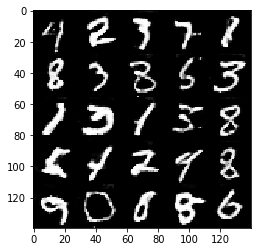

Batch: 1701 - Discriminator Loss: 0.6230238676071167 - Generator Loss: 2.18782377243042
Batch: 1702 - Discriminator Loss: 0.5985324382781982 - Generator Loss: 4.067317485809326
Batch: 1703 - Discriminator Loss: 0.7254106998443604 - Generator Loss: 1.9722540378570557
Batch: 1704 - Discriminator Loss: 0.7696493864059448 - Generator Loss: 5.665518760681152
Batch: 1705 - Discriminator Loss: 1.2048026323318481 - Generator Loss: 0.98859041929245
Batch: 1706 - Discriminator Loss: 0.6675126552581787 - Generator Loss: 3.7835888862609863
Batch: 1707 - Discriminator Loss: 0.6892262697219849 - Generator Loss: 1.5051288604736328
Batch: 1708 - Discriminator Loss: 0.9420874118804932 - Generator Loss: 4.672877788543701
Batch: 1709 - Discriminator Loss: 1.163777232170105 - Generator Loss: 0.5793942213058472
Batch: 1710 - Discriminator Loss: 1.1125496625900269 - Generator Loss: 5.383553981781006
Batch: 1711 - Discriminator Loss: 0.9856005907058716 - Generator Loss: 1.4637863636016846
Batch: 1712 - Discr

Batch: 1793 - Discriminator Loss: 0.576748788356781 - Generator Loss: 3.912681818008423
Batch: 1794 - Discriminator Loss: 0.5999064445495605 - Generator Loss: 2.252901554107666
Batch: 1795 - Discriminator Loss: 0.6207754611968994 - Generator Loss: 2.626053810119629
Batch: 1796 - Discriminator Loss: 0.6503616571426392 - Generator Loss: 4.201756000518799
Batch: 1797 - Discriminator Loss: 0.8124822378158569 - Generator Loss: 1.769651174545288
Batch: 1798 - Discriminator Loss: 0.8325484991073608 - Generator Loss: 4.909265518188477
Batch: 1799 - Discriminator Loss: 0.7566187977790833 - Generator Loss: 1.6099562644958496
Batch: 1800 - Discriminator Loss: 0.8532277941703796 - Generator Loss: 4.681574821472168


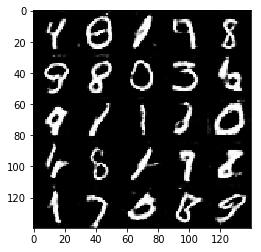

Batch: 1801 - Discriminator Loss: 1.083855390548706 - Generator Loss: 1.464200735092163
Batch: 1802 - Discriminator Loss: 1.066981315612793 - Generator Loss: 4.910429000854492
Batch: 1803 - Discriminator Loss: 0.8366255760192871 - Generator Loss: 2.1391143798828125
Batch: 1804 - Discriminator Loss: 0.5306251645088196 - Generator Loss: 3.3805055618286133
Batch: 1805 - Discriminator Loss: 0.521943986415863 - Generator Loss: 3.442866802215576
Batch: 1806 - Discriminator Loss: 0.5455034971237183 - Generator Loss: 3.2547097206115723
Batch: 1807 - Discriminator Loss: 0.8671652674674988 - Generator Loss: 1.6712086200714111
Batch: 1808 - Discriminator Loss: 1.0826902389526367 - Generator Loss: 5.286905765533447
Batch: 1809 - Discriminator Loss: 0.9719057083129883 - Generator Loss: 1.4347724914550781
Batch: 1810 - Discriminator Loss: 0.6433283090591431 - Generator Loss: 3.6912243366241455
Batch: 1811 - Discriminator Loss: 0.4218880534172058 - Generator Loss: 3.350123882293701
Batch: 1812 - Disc

In [ ]:
batch_size = 32
z_dim = 200
learning_rate = .0005
beta1 = 0.2

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Batch: 0 - Discriminator Loss: 2.00948429107666 - Generator Loss: 5.732600688934326


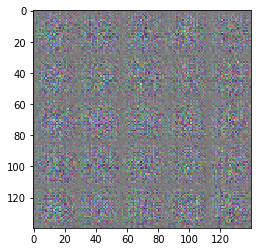

Batch: 1 - Discriminator Loss: 1.0964491367340088 - Generator Loss: 3.362760305404663
Batch: 2 - Discriminator Loss: 2.15445876121521 - Generator Loss: 6.587496280670166
Batch: 3 - Discriminator Loss: 0.6136296391487122 - Generator Loss: 4.987675666809082
Batch: 4 - Discriminator Loss: 1.0496985912322998 - Generator Loss: 6.373452186584473
Batch: 5 - Discriminator Loss: 0.7071743011474609 - Generator Loss: 3.439042091369629
Batch: 6 - Discriminator Loss: 1.6447118520736694 - Generator Loss: 10.807591438293457
Batch: 7 - Discriminator Loss: 0.6512885093688965 - Generator Loss: 7.6335954666137695
Batch: 8 - Discriminator Loss: 0.6416115760803223 - Generator Loss: 4.547512054443359
Batch: 9 - Discriminator Loss: 1.2265849113464355 - Generator Loss: 11.381227493286133
Batch: 10 - Discriminator Loss: 1.7033865451812744 - Generator Loss: 5.277448654174805
Batch: 11 - Discriminator Loss: 1.7314155101776123 - Generator Loss: 10.331562042236328
Batch: 12 - Discriminator Loss: 0.6853018403053284

Batch: 96 - Discriminator Loss: 0.47521018981933594 - Generator Loss: 5.034088611602783
Batch: 97 - Discriminator Loss: 0.5067470073699951 - Generator Loss: 5.2839555740356445
Batch: 98 - Discriminator Loss: 0.47259393334388733 - Generator Loss: 5.080591201782227
Batch: 99 - Discriminator Loss: 0.45261961221694946 - Generator Loss: 5.409282207489014
Batch: 100 - Discriminator Loss: 0.5419944524765015 - Generator Loss: 4.679269790649414


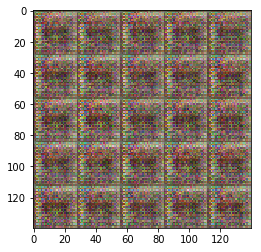

Batch: 101 - Discriminator Loss: 0.48767900466918945 - Generator Loss: 6.02908992767334
Batch: 102 - Discriminator Loss: 0.4171195328235626 - Generator Loss: 5.327346324920654
Batch: 103 - Discriminator Loss: 0.41514185070991516 - Generator Loss: 5.024683952331543
Batch: 104 - Discriminator Loss: 0.4477789103984833 - Generator Loss: 5.243201732635498
Batch: 105 - Discriminator Loss: 0.4515383839607239 - Generator Loss: 4.878772258758545
Batch: 106 - Discriminator Loss: 0.46288859844207764 - Generator Loss: 5.315686225891113
Batch: 107 - Discriminator Loss: 0.43779340386390686 - Generator Loss: 4.811439037322998
Batch: 108 - Discriminator Loss: 0.4460667371749878 - Generator Loss: 5.520183563232422
Batch: 109 - Discriminator Loss: 0.41836681962013245 - Generator Loss: 4.840688228607178
Batch: 110 - Discriminator Loss: 0.45013290643692017 - Generator Loss: 5.261688232421875
Batch: 111 - Discriminator Loss: 0.44668516516685486 - Generator Loss: 4.479279041290283
Batch: 112 - Discriminator

Batch: 194 - Discriminator Loss: 0.44337862730026245 - Generator Loss: 5.742544174194336
Batch: 195 - Discriminator Loss: 0.44214653968811035 - Generator Loss: 3.6320488452911377
Batch: 196 - Discriminator Loss: 0.4239444136619568 - Generator Loss: 4.786755084991455
Batch: 197 - Discriminator Loss: 0.38396862149238586 - Generator Loss: 4.219290733337402
Batch: 198 - Discriminator Loss: 0.38273876905441284 - Generator Loss: 4.1722893714904785
Batch: 199 - Discriminator Loss: 0.38575586676597595 - Generator Loss: 4.216755390167236
Batch: 200 - Discriminator Loss: 0.4039084315299988 - Generator Loss: 3.986701726913452


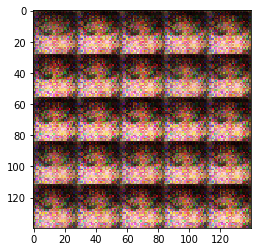

Batch: 201 - Discriminator Loss: 0.40359359979629517 - Generator Loss: 4.367090225219727
Batch: 202 - Discriminator Loss: 0.4254399240016937 - Generator Loss: 3.3348398208618164
Batch: 203 - Discriminator Loss: 0.43144750595092773 - Generator Loss: 5.486303329467773
Batch: 204 - Discriminator Loss: 0.4041009843349457 - Generator Loss: 4.352789402008057
Batch: 205 - Discriminator Loss: 0.394079327583313 - Generator Loss: 3.8265390396118164
Batch: 206 - Discriminator Loss: 0.41895344853401184 - Generator Loss: 4.631316661834717
Batch: 207 - Discriminator Loss: 0.38544297218322754 - Generator Loss: 4.171311855316162
Batch: 208 - Discriminator Loss: 0.41164588928222656 - Generator Loss: 3.8752622604370117
Batch: 209 - Discriminator Loss: 0.44174882769584656 - Generator Loss: 4.130062103271484
Batch: 210 - Discriminator Loss: 0.3978894352912903 - Generator Loss: 4.5715227127075195
Batch: 211 - Discriminator Loss: 0.41139528155326843 - Generator Loss: 4.012633323669434
Batch: 212 - Discrimin

Batch: 294 - Discriminator Loss: 0.4778760075569153 - Generator Loss: 5.719736099243164
Batch: 295 - Discriminator Loss: 0.5577532052993774 - Generator Loss: 1.8900232315063477
Batch: 296 - Discriminator Loss: 1.1102428436279297 - Generator Loss: 15.255382537841797
Batch: 297 - Discriminator Loss: 4.19722318649292 - Generator Loss: 3.6491687297821045
Batch: 298 - Discriminator Loss: 0.9622898697853088 - Generator Loss: 5.758786201477051
Batch: 299 - Discriminator Loss: 1.148492455482483 - Generator Loss: 5.983162879943848
Batch: 300 - Discriminator Loss: 0.8557831048965454 - Generator Loss: 3.5567729473114014


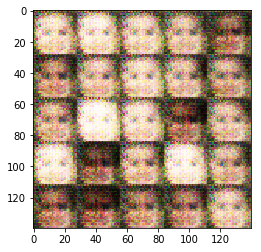

Batch: 301 - Discriminator Loss: 0.8287962675094604 - Generator Loss: 5.7512664794921875
Batch: 302 - Discriminator Loss: 0.9541590213775635 - Generator Loss: 0.8171261548995972
Batch: 303 - Discriminator Loss: 1.8295254707336426 - Generator Loss: 11.62554931640625
Batch: 304 - Discriminator Loss: 4.643320083618164 - Generator Loss: 3.5510787963867188
Batch: 305 - Discriminator Loss: 0.6993546485900879 - Generator Loss: 3.0775251388549805
Batch: 306 - Discriminator Loss: 0.8144748210906982 - Generator Loss: 4.944803237915039
Batch: 307 - Discriminator Loss: 1.0056143999099731 - Generator Loss: 1.4990044832229614
Batch: 308 - Discriminator Loss: 1.3543834686279297 - Generator Loss: 8.372325897216797
Batch: 309 - Discriminator Loss: 2.6147680282592773 - Generator Loss: 2.2441329956054688
Batch: 310 - Discriminator Loss: 0.8300831913948059 - Generator Loss: 3.966928720474243
Batch: 311 - Discriminator Loss: 0.6971051692962646 - Generator Loss: 2.312973737716675
Batch: 312 - Discriminator 

Batch: 394 - Discriminator Loss: 0.6835716366767883 - Generator Loss: 3.4902901649475098
Batch: 395 - Discriminator Loss: 0.8787611722946167 - Generator Loss: 1.912756323814392
Batch: 396 - Discriminator Loss: 0.8769476413726807 - Generator Loss: 5.704822063446045
Batch: 397 - Discriminator Loss: 0.8878247141838074 - Generator Loss: 2.414088726043701
Batch: 398 - Discriminator Loss: 0.8466456532478333 - Generator Loss: 4.93427038192749
Batch: 399 - Discriminator Loss: 0.6673696041107178 - Generator Loss: 2.47822904586792
Batch: 400 - Discriminator Loss: 0.9076945781707764 - Generator Loss: 5.221987724304199


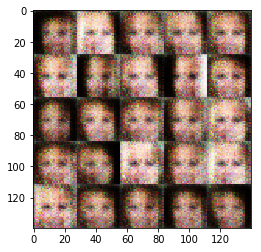

Batch: 401 - Discriminator Loss: 0.839480996131897 - Generator Loss: 2.08602237701416
Batch: 402 - Discriminator Loss: 0.9520083069801331 - Generator Loss: 6.05458402633667
Batch: 403 - Discriminator Loss: 1.1277227401733398 - Generator Loss: 2.1597039699554443
Batch: 404 - Discriminator Loss: 1.061697006225586 - Generator Loss: 6.631487846374512
Batch: 405 - Discriminator Loss: 0.9344825148582458 - Generator Loss: 3.016819477081299
Batch: 406 - Discriminator Loss: 0.7726070880889893 - Generator Loss: 4.163538932800293
Batch: 407 - Discriminator Loss: 0.6209691762924194 - Generator Loss: 2.9324960708618164
Batch: 408 - Discriminator Loss: 0.9078348278999329 - Generator Loss: 4.192479610443115
Batch: 409 - Discriminator Loss: 0.9983097314834595 - Generator Loss: 1.4337190389633179
Batch: 410 - Discriminator Loss: 1.1880784034729004 - Generator Loss: 7.191545486450195
Batch: 411 - Discriminator Loss: 1.5208097696304321 - Generator Loss: 3.1623682975769043
Batch: 412 - Discriminator Loss:

Batch: 494 - Discriminator Loss: 0.6776973009109497 - Generator Loss: 2.4883267879486084
Batch: 495 - Discriminator Loss: 0.8053970336914062 - Generator Loss: 3.806375503540039
Batch: 496 - Discriminator Loss: 0.7709774971008301 - Generator Loss: 2.1783673763275146
Batch: 497 - Discriminator Loss: 1.1502487659454346 - Generator Loss: 5.1198554039001465
Batch: 498 - Discriminator Loss: 1.0849794149398804 - Generator Loss: 2.224184513092041
Batch: 499 - Discriminator Loss: 1.3579339981079102 - Generator Loss: 6.331741809844971
Batch: 500 - Discriminator Loss: 1.2414847612380981 - Generator Loss: 2.498049736022949


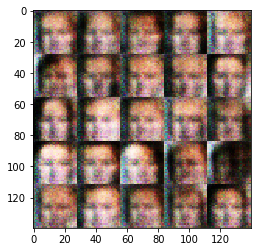

Batch: 501 - Discriminator Loss: 0.9952305555343628 - Generator Loss: 4.228544235229492
Batch: 502 - Discriminator Loss: 0.9111489057540894 - Generator Loss: 1.7741190195083618
Batch: 503 - Discriminator Loss: 1.2470964193344116 - Generator Loss: 5.694946765899658
Batch: 504 - Discriminator Loss: 1.5751851797103882 - Generator Loss: 1.5751011371612549
Batch: 505 - Discriminator Loss: 1.299013376235962 - Generator Loss: 5.204006195068359
Batch: 506 - Discriminator Loss: 0.9738644361495972 - Generator Loss: 2.374272108078003
Batch: 507 - Discriminator Loss: 0.8029749989509583 - Generator Loss: 2.9310286045074463
Batch: 508 - Discriminator Loss: 0.7035540342330933 - Generator Loss: 2.7317795753479004
Batch: 509 - Discriminator Loss: 0.7247276902198792 - Generator Loss: 2.417431354522705
Batch: 510 - Discriminator Loss: 0.8772181272506714 - Generator Loss: 3.3053622245788574
Batch: 511 - Discriminator Loss: 0.9397030472755432 - Generator Loss: 1.4763829708099365
Batch: 512 - Discriminator 

Batch: 594 - Discriminator Loss: 0.7087957859039307 - Generator Loss: 3.2420904636383057
Batch: 595 - Discriminator Loss: 0.7214937210083008 - Generator Loss: 1.9936020374298096
Batch: 596 - Discriminator Loss: 0.7432084083557129 - Generator Loss: 3.2717092037200928
Batch: 597 - Discriminator Loss: 0.6755473017692566 - Generator Loss: 1.8775262832641602
Batch: 598 - Discriminator Loss: 0.8239147663116455 - Generator Loss: 3.887110710144043
Batch: 599 - Discriminator Loss: 0.8500454425811768 - Generator Loss: 1.2670392990112305
Batch: 600 - Discriminator Loss: 1.0615589618682861 - Generator Loss: 5.218723773956299


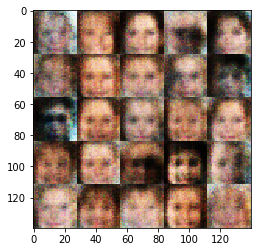

Batch: 601 - Discriminator Loss: 1.2057826519012451 - Generator Loss: 1.4860565662384033
Batch: 602 - Discriminator Loss: 1.2321488857269287 - Generator Loss: 4.461562633514404
Batch: 603 - Discriminator Loss: 1.1790962219238281 - Generator Loss: 0.9827759265899658
Batch: 604 - Discriminator Loss: 1.394798755645752 - Generator Loss: 5.335539817810059
Batch: 605 - Discriminator Loss: 1.6486302614212036 - Generator Loss: 0.9934305548667908
Batch: 606 - Discriminator Loss: 1.091245174407959 - Generator Loss: 4.261734485626221
Batch: 607 - Discriminator Loss: 1.0973341464996338 - Generator Loss: 1.4782191514968872
Batch: 608 - Discriminator Loss: 0.9772130250930786 - Generator Loss: 3.499692440032959
Batch: 609 - Discriminator Loss: 0.8207858800888062 - Generator Loss: 1.6894842386245728
Batch: 610 - Discriminator Loss: 0.8275173902511597 - Generator Loss: 2.812436103820801
Batch: 611 - Discriminator Loss: 0.8133021593093872 - Generator Loss: 1.5995904207229614
Batch: 612 - Discriminator L

Batch: 694 - Discriminator Loss: 0.9223104119300842 - Generator Loss: 1.4367690086364746
Batch: 695 - Discriminator Loss: 0.9464580416679382 - Generator Loss: 3.035848617553711
Batch: 696 - Discriminator Loss: 0.8486703634262085 - Generator Loss: 1.5529476404190063
Batch: 697 - Discriminator Loss: 0.8370904922485352 - Generator Loss: 3.288069009780884
Batch: 698 - Discriminator Loss: 1.0302447080612183 - Generator Loss: 1.0881781578063965
Batch: 699 - Discriminator Loss: 1.1449036598205566 - Generator Loss: 3.9375
Batch: 700 - Discriminator Loss: 1.2022578716278076 - Generator Loss: 1.1452271938323975


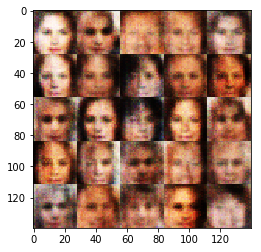

Batch: 701 - Discriminator Loss: 1.1824074983596802 - Generator Loss: 3.4523425102233887
Batch: 702 - Discriminator Loss: 0.8862015008926392 - Generator Loss: 1.3150763511657715
Batch: 703 - Discriminator Loss: 0.9703076481819153 - Generator Loss: 3.53615665435791
Batch: 704 - Discriminator Loss: 1.0164375305175781 - Generator Loss: 1.115204095840454
Batch: 705 - Discriminator Loss: 1.1035802364349365 - Generator Loss: 4.271426200866699
Batch: 706 - Discriminator Loss: 1.0074920654296875 - Generator Loss: 1.3541853427886963
Batch: 707 - Discriminator Loss: 0.9031225442886353 - Generator Loss: 3.192509651184082
Batch: 708 - Discriminator Loss: 1.0318723917007446 - Generator Loss: 1.08040452003479
Batch: 709 - Discriminator Loss: 1.2121613025665283 - Generator Loss: 3.927912712097168
Batch: 710 - Discriminator Loss: 1.198516845703125 - Generator Loss: 1.2699954509735107
Batch: 711 - Discriminator Loss: 1.0147387981414795 - Generator Loss: 2.8456454277038574
Batch: 712 - Discriminator Los

Batch: 794 - Discriminator Loss: 1.054351806640625 - Generator Loss: 1.3991103172302246
Batch: 795 - Discriminator Loss: 1.0694488286972046 - Generator Loss: 3.4971764087677
Batch: 796 - Discriminator Loss: 1.0096030235290527 - Generator Loss: 1.4127857685089111
Batch: 797 - Discriminator Loss: 0.9649707674980164 - Generator Loss: 2.6494455337524414
Batch: 798 - Discriminator Loss: 0.9238382577896118 - Generator Loss: 1.4162859916687012
Batch: 799 - Discriminator Loss: 1.0164750814437866 - Generator Loss: 2.4602584838867188
Batch: 800 - Discriminator Loss: 0.8425960540771484 - Generator Loss: 1.8057578802108765


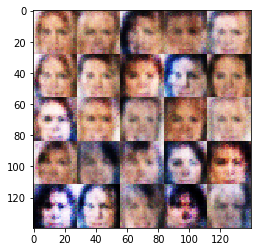

Batch: 801 - Discriminator Loss: 0.9317414164543152 - Generator Loss: 1.7400681972503662
Batch: 802 - Discriminator Loss: 0.9281966686248779 - Generator Loss: 1.7283639907836914
Batch: 803 - Discriminator Loss: 0.8285849094390869 - Generator Loss: 2.6278295516967773
Batch: 804 - Discriminator Loss: 0.8320176005363464 - Generator Loss: 1.5062708854675293
Batch: 805 - Discriminator Loss: 0.900201678276062 - Generator Loss: 3.057859420776367
Batch: 806 - Discriminator Loss: 0.9675975441932678 - Generator Loss: 1.2135751247406006
Batch: 807 - Discriminator Loss: 1.059404730796814 - Generator Loss: 3.4383468627929688
Batch: 808 - Discriminator Loss: 0.967713475227356 - Generator Loss: 1.3314313888549805
Batch: 809 - Discriminator Loss: 1.1328675746917725 - Generator Loss: 3.746727466583252
Batch: 810 - Discriminator Loss: 1.0861899852752686 - Generator Loss: 1.2973893880844116
Batch: 811 - Discriminator Loss: 1.25094735622406 - Generator Loss: 4.219362258911133
Batch: 812 - Discriminator Lo

Batch: 894 - Discriminator Loss: 1.2571063041687012 - Generator Loss: 1.037358283996582
Batch: 895 - Discriminator Loss: 1.3154144287109375 - Generator Loss: 4.277557373046875
Batch: 896 - Discriminator Loss: 1.375288963317871 - Generator Loss: 1.243499755859375
Batch: 897 - Discriminator Loss: 1.016379475593567 - Generator Loss: 3.203512191772461
Batch: 898 - Discriminator Loss: 0.9613417387008667 - Generator Loss: 1.6390935182571411
Batch: 899 - Discriminator Loss: 0.8395498394966125 - Generator Loss: 2.348320722579956
Batch: 900 - Discriminator Loss: 0.8503479361534119 - Generator Loss: 1.9705605506896973


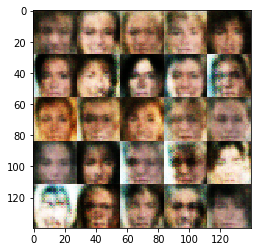

Batch: 901 - Discriminator Loss: 0.8695439100265503 - Generator Loss: 2.0429515838623047
Batch: 902 - Discriminator Loss: 0.8709744811058044 - Generator Loss: 2.0469484329223633
Batch: 903 - Discriminator Loss: 0.8757132291793823 - Generator Loss: 2.000180721282959
Batch: 904 - Discriminator Loss: 0.8843920230865479 - Generator Loss: 2.1433112621307373
Batch: 905 - Discriminator Loss: 0.8561868667602539 - Generator Loss: 1.92018723487854
Batch: 906 - Discriminator Loss: 0.8622294664382935 - Generator Loss: 2.591459274291992
Batch: 907 - Discriminator Loss: 0.9169060587882996 - Generator Loss: 1.4035238027572632
Batch: 908 - Discriminator Loss: 0.9568465352058411 - Generator Loss: 2.8550543785095215
Batch: 909 - Discriminator Loss: 0.9792709350585938 - Generator Loss: 1.2252726554870605
Batch: 910 - Discriminator Loss: 1.0731464624404907 - Generator Loss: 3.598728656768799
Batch: 911 - Discriminator Loss: 1.2737524509429932 - Generator Loss: 0.8349958062171936
Batch: 912 - Discriminator

Batch: 994 - Discriminator Loss: 1.3771865367889404 - Generator Loss: 1.041844129562378
Batch: 995 - Discriminator Loss: 1.411882996559143 - Generator Loss: 4.296171188354492
Batch: 996 - Discriminator Loss: 1.2589515447616577 - Generator Loss: 1.4009404182434082
Batch: 997 - Discriminator Loss: 1.0603731870651245 - Generator Loss: 3.150083541870117
Batch: 998 - Discriminator Loss: 0.9241917133331299 - Generator Loss: 1.587120771408081
Batch: 999 - Discriminator Loss: 1.0613269805908203 - Generator Loss: 2.8114776611328125
Batch: 1000 - Discriminator Loss: 1.0343080759048462 - Generator Loss: 1.4709229469299316


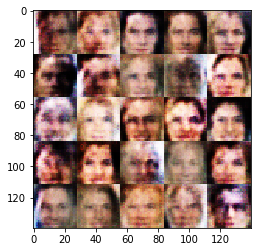

Batch: 1001 - Discriminator Loss: 1.003122091293335 - Generator Loss: 3.267638683319092
Batch: 1002 - Discriminator Loss: 1.0124202966690063 - Generator Loss: 1.2580366134643555
Batch: 1003 - Discriminator Loss: 1.018190622329712 - Generator Loss: 3.264204502105713
Batch: 1004 - Discriminator Loss: 1.0580456256866455 - Generator Loss: 1.1506975889205933
Batch: 1005 - Discriminator Loss: 1.1664154529571533 - Generator Loss: 3.7911617755889893
Batch: 1006 - Discriminator Loss: 1.1686478853225708 - Generator Loss: 1.3017585277557373
Batch: 1007 - Discriminator Loss: 1.0427144765853882 - Generator Loss: 3.1061630249023438
Batch: 1008 - Discriminator Loss: 0.8525427579879761 - Generator Loss: 1.6984630823135376
Batch: 1009 - Discriminator Loss: 0.943557858467102 - Generator Loss: 2.4408836364746094
Batch: 1010 - Discriminator Loss: 0.9543572664260864 - Generator Loss: 1.5506553649902344
Batch: 1011 - Discriminator Loss: 0.9738926887512207 - Generator Loss: 2.8210511207580566
Batch: 1012 - D

Batch: 1093 - Discriminator Loss: 1.1503167152404785 - Generator Loss: 3.285984992980957
Batch: 1094 - Discriminator Loss: 1.2258179187774658 - Generator Loss: 1.0477564334869385
Batch: 1095 - Discriminator Loss: 1.3008232116699219 - Generator Loss: 3.466264247894287
Batch: 1096 - Discriminator Loss: 1.1355842351913452 - Generator Loss: 1.2761855125427246
Batch: 1097 - Discriminator Loss: 1.0693881511688232 - Generator Loss: 3.019110918045044
Batch: 1098 - Discriminator Loss: 0.944442629814148 - Generator Loss: 1.504689335823059
Batch: 1099 - Discriminator Loss: 0.9478808045387268 - Generator Loss: 2.51654314994812
Batch: 1100 - Discriminator Loss: 0.8873034119606018 - Generator Loss: 1.484140157699585


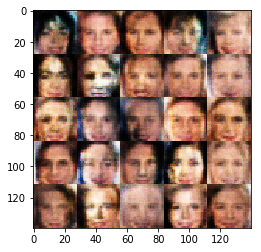

Batch: 1101 - Discriminator Loss: 0.9261581301689148 - Generator Loss: 2.7272160053253174
Batch: 1102 - Discriminator Loss: 1.0399272441864014 - Generator Loss: 1.0736889839172363
Batch: 1103 - Discriminator Loss: 1.2558925151824951 - Generator Loss: 3.5012738704681396
Batch: 1104 - Discriminator Loss: 1.2341420650482178 - Generator Loss: 1.1688673496246338
Batch: 1105 - Discriminator Loss: 1.079107642173767 - Generator Loss: 2.8245160579681396
Batch: 1106 - Discriminator Loss: 1.003318428993225 - Generator Loss: 1.2535589933395386
Batch: 1107 - Discriminator Loss: 0.9595405459403992 - Generator Loss: 3.012228488922119
Batch: 1108 - Discriminator Loss: 0.9661171436309814 - Generator Loss: 1.1694624423980713
Batch: 1109 - Discriminator Loss: 1.0782523155212402 - Generator Loss: 3.07987117767334
Batch: 1110 - Discriminator Loss: 1.1288796663284302 - Generator Loss: 1.2399239540100098
Batch: 1111 - Discriminator Loss: 1.0539638996124268 - Generator Loss: 3.0304484367370605
Batch: 1112 - D

Batch: 1193 - Discriminator Loss: 0.8849666118621826 - Generator Loss: 1.448742151260376
Batch: 1194 - Discriminator Loss: 0.9076337814331055 - Generator Loss: 2.566070556640625
Batch: 1195 - Discriminator Loss: 0.8832484483718872 - Generator Loss: 1.498406171798706
Batch: 1196 - Discriminator Loss: 0.94432532787323 - Generator Loss: 2.4156339168548584
Batch: 1197 - Discriminator Loss: 0.8613826632499695 - Generator Loss: 1.54042649269104
Batch: 1198 - Discriminator Loss: 0.9291127920150757 - Generator Loss: 2.724670171737671
Batch: 1199 - Discriminator Loss: 1.0138745307922363 - Generator Loss: 0.9989080429077148
Batch: 1200 - Discriminator Loss: 1.1901795864105225 - Generator Loss: 3.380533218383789


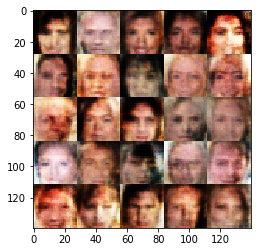

Batch: 1201 - Discriminator Loss: 1.2900117635726929 - Generator Loss: 0.8841649889945984
Batch: 1202 - Discriminator Loss: 1.4090381860733032 - Generator Loss: 3.939953565597534
Batch: 1203 - Discriminator Loss: 1.5658096075057983 - Generator Loss: 0.846877932548523
Batch: 1204 - Discriminator Loss: 1.3593623638153076 - Generator Loss: 3.429471254348755
Batch: 1205 - Discriminator Loss: 1.102618932723999 - Generator Loss: 1.273713231086731
Batch: 1206 - Discriminator Loss: 0.9533380270004272 - Generator Loss: 2.6224498748779297
Batch: 1207 - Discriminator Loss: 0.8259669542312622 - Generator Loss: 1.6590951681137085
Batch: 1208 - Discriminator Loss: 0.9887218475341797 - Generator Loss: 2.58545184135437
Batch: 1209 - Discriminator Loss: 1.030735731124878 - Generator Loss: 1.3311446905136108
Batch: 1210 - Discriminator Loss: 1.2533576488494873 - Generator Loss: 2.899217128753662
Batch: 1211 - Discriminator Loss: 1.2458395957946777 - Generator Loss: 0.9467054009437561
Batch: 1212 - Discr

Batch: 1293 - Discriminator Loss: 0.9840878248214722 - Generator Loss: 2.6327438354492188
Batch: 1294 - Discriminator Loss: 0.9850257635116577 - Generator Loss: 1.020059585571289
Batch: 1295 - Discriminator Loss: 1.21616792678833 - Generator Loss: 3.5951156616210938
Batch: 1296 - Discriminator Loss: 1.136538028717041 - Generator Loss: 1.19428288936615
Batch: 1297 - Discriminator Loss: 1.012674331665039 - Generator Loss: 2.4624183177948
Batch: 1298 - Discriminator Loss: 0.7961162328720093 - Generator Loss: 1.599125862121582
Batch: 1299 - Discriminator Loss: 0.8648191690444946 - Generator Loss: 2.4498016834259033
Batch: 1300 - Discriminator Loss: 0.8507949113845825 - Generator Loss: 1.5114760398864746


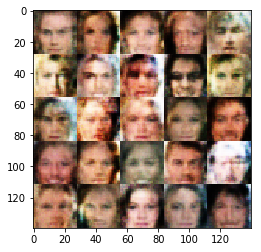

Batch: 1301 - Discriminator Loss: 0.8720142841339111 - Generator Loss: 2.496053695678711
Batch: 1302 - Discriminator Loss: 0.8296401500701904 - Generator Loss: 1.4368330240249634
Batch: 1303 - Discriminator Loss: 0.8690328001976013 - Generator Loss: 2.6215577125549316
Batch: 1304 - Discriminator Loss: 0.8039527535438538 - Generator Loss: 1.491117000579834
Batch: 1305 - Discriminator Loss: 0.8848589658737183 - Generator Loss: 2.45037579536438
Batch: 1306 - Discriminator Loss: 0.7794968485832214 - Generator Loss: 1.654128074645996
Batch: 1307 - Discriminator Loss: 0.7775508165359497 - Generator Loss: 2.3255386352539062
Batch: 1308 - Discriminator Loss: 0.8588698506355286 - Generator Loss: 1.3780076503753662
Batch: 1309 - Discriminator Loss: 1.0477761030197144 - Generator Loss: 3.186370849609375
Batch: 1310 - Discriminator Loss: 1.193519115447998 - Generator Loss: 1.0294075012207031
Batch: 1311 - Discriminator Loss: 1.3522173166275024 - Generator Loss: 3.728698492050171
Batch: 1312 - Disc

Batch: 1393 - Discriminator Loss: 1.0439050197601318 - Generator Loss: 3.1009788513183594
Batch: 1394 - Discriminator Loss: 1.0817903280258179 - Generator Loss: 1.2861566543579102
Batch: 1395 - Discriminator Loss: 0.9963481426239014 - Generator Loss: 2.567108154296875
Batch: 1396 - Discriminator Loss: 0.7912415266036987 - Generator Loss: 1.6074328422546387
Batch: 1397 - Discriminator Loss: 0.7998589277267456 - Generator Loss: 1.828333854675293
Batch: 1398 - Discriminator Loss: 0.7097331285476685 - Generator Loss: 2.0183143615722656
Batch: 1399 - Discriminator Loss: 0.7142003774642944 - Generator Loss: 1.8679418563842773
Batch: 1400 - Discriminator Loss: 0.6939641833305359 - Generator Loss: 1.9487369060516357


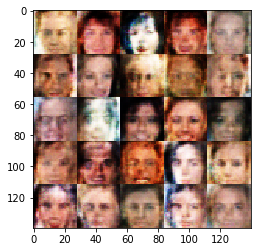

Batch: 1401 - Discriminator Loss: 0.7345110177993774 - Generator Loss: 2.1124048233032227
Batch: 1402 - Discriminator Loss: 0.6800074577331543 - Generator Loss: 1.7975726127624512
Batch: 1403 - Discriminator Loss: 0.7308783531188965 - Generator Loss: 2.1756093502044678
Batch: 1404 - Discriminator Loss: 0.6729683876037598 - Generator Loss: 1.8008795976638794
Batch: 1405 - Discriminator Loss: 0.7079885005950928 - Generator Loss: 2.490098714828491
Batch: 1406 - Discriminator Loss: 0.6635250449180603 - Generator Loss: 1.6660696268081665
Batch: 1407 - Discriminator Loss: 0.8458573818206787 - Generator Loss: 3.1857359409332275
Batch: 1408 - Discriminator Loss: 0.9086118340492249 - Generator Loss: 1.3075016736984253
Batch: 1409 - Discriminator Loss: 1.107691764831543 - Generator Loss: 3.3910794258117676
Batch: 1410 - Discriminator Loss: 1.1313990354537964 - Generator Loss: 1.0545275211334229
Batch: 1411 - Discriminator Loss: 1.0885437726974487 - Generator Loss: 3.4528067111968994
Batch: 1412 

Batch: 1493 - Discriminator Loss: 0.6424486041069031 - Generator Loss: 1.779552698135376


In [ ]:
batch_size = 128
z_dim = 200
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.